<a href="https://colab.research.google.com/github/martinkenas/Road-Segmentation-for-type-wetness-and-roughness/blob/main/model_training_scripts/Kelio_Bukle_YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title PILNAS BŪKLES 1. Sąranka ir diegimas

# Įdiegiame būtinas bibliotekas
!pip install ultralytics


from sklearn.model_selection import train_test_split
#@title 1. Import Libraries (Combined)
import os
import yaml
import random
import shutil
from datetime import datetime
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split
import numpy as np
import cv2 # Make sure cv2 is imported early if used in helper functions
import albumentations as A # Import albumentations
from tqdm import tqdm # Import tqdm
import torch # Import torch
import glob # Import glob
import logging # Import logging
from google.colab import drive
from IPython.display import display, Image # Import display tools
from ultralytics import YOLO # Import YOLO
from ultralytics.data.dataset import YOLODataset # Import YOLODataset
from functools import partial # Import partial
import ultralytics.data.build as build # Import build
import time # Import time
import traceback # Import traceback


# Prijungiame Google Drive
drive.mount('/content/drive')

print("Sąranka baigta!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
#@title 2. Projekto struktūros konfigūravimas

# Base directories for road wetness segmentation
base_dir = '/content/drive/MyDrive/Dangos Dregmes Nustatymas'
print(f"Pagrindinis katalogas: {base_dir}")

# Source directories for masked images and labels
images_dir = os.path.join(base_dir, 'Images(kaukes)')
labels_dirs = {
    'sausas': os.path.join(base_dir, 'labels2', 'Sausas'),   # klasė 3 konvertuojama į 0
    'slapias': os.path.join(base_dir, 'labels2', 'Slapias')  # klasė 4 konvertuojama į 1
}

# Sukuriame laiko žymą unikaliam projekto paleidimui
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
project_dir = os.path.join(base_dir, f'road_wetness_seg_{timestamp}')
os.makedirs(project_dir, exist_ok=True)

# Rezultatų katalogai
results_dir = os.path.join(project_dir, 'results')
predictions_dir = os.path.join(project_dir, 'predictions')
exports_dir = os.path.join(project_dir, 'exports')
os.makedirs(results_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)
os.makedirs(exports_dir, exist_ok=True)

# Sukuriame duomenų rinkinio katalogų struktūrą
dataset_root = os.path.join(base_dir, f'road_wetness_dataset_{timestamp}')
os.makedirs(dataset_root, exist_ok=True)

# Sukuriame YOLO duomenų rinkinio struktūrą
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_root, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(dataset_root, 'labels', split), exist_ok=True)



Pagrindinis katalogas: /content/drive/MyDrive/Dangos Dregmes Nustatymas


In [ ]:
#@title 3. Duomenų rinkinio analizė ir padalijimų sukūrimas

def analyze_dataset():
    """Analizuoti duomenų rinkinį ir sukurti padalijimus"""
    # Gauname visus pažymėtus failus iš kiekvieno katalogo
    all_files = {}

    # Skaičiuojame failus kiekvienam drėgmės tipui
    type_counts = {}

    for wetness_type, label_dir in labels_dirs.items():
        files = []
        class_id = {"sausas": 0, "slapias": 1}[wetness_type]  # Konvertuojame 3,4 į 0,1

        # Gauname visus txt failus, išskyrus classes.txt
        for file in os.listdir(label_dir):
            if file.endswith('.txt') and file != 'classes.txt':
                base_name = os.path.splitext(file)[0]
                # Tikriname, ar egzistuoja atitinkamas vaizdas
                img_path = None
                for ext in ['.jpg', '.jpeg', '.png']:
                    if os.path.exists(os.path.join(images_dir, base_name + ext)):
                        img_path = os.path.join(images_dir, base_name + ext)
                        break

                if img_path:
                    files.append({
                        'base_name': base_name,
                        'img_path': img_path,
                        'label_path': os.path.join(label_dir, file),
                        'wetness_type': wetness_type,
                        'class_id': class_id # Use the target class ID (0 or 1)
                    })

        all_files[wetness_type] = files
        type_counts[wetness_type] = len(files)

    # Spausdiname statistiką
    print("\nDuomenų rinkinio statistika:")
    total_files = sum(type_counts.values())
    for wetness_type, count in type_counts.items():
        print(f"  {wetness_type}: {count} failai ({count/total_files*100:.1f}%)")
    print(f"  Iš viso: {total_files} failai")

    # Sukuriame padalijimus (70% train, 15% val, 15% test) - Using "Better" version's split logic
    splits = {'train': [], 'val': [], 'test': []}

    for wetness_type, files in all_files.items():
        # Padalijame failus
        train_files, temp = train_test_split(
            files, test_size=0.3, random_state=42
        )
        val_files, test_files = train_test_split(
            temp, test_size=0.5, random_state=42 # 0.3 * 0.5 = 0.15 for val and test
        )

        # Pridedame į padalijimus
        splits['train'].extend(train_files)
        splits['val'].extend(val_files)
        splits['test'].extend(test_files)

    # Spausdiname padalijimų statistiką
    print("\nPadalijimų statistika:")
    for split_name, files in splits.items():
        print(f"  {split_name}: {len(files)} failai")

        # Skaičiuojame pagal drėgmės tipą
        split_counts = {}
        for file in files:
            wt = file['wetness_type']
            split_counts[wt] = split_counts.get(wt, 0) + 1

        for wt, count in split_counts.items():
            print(f"    - {wt}: {count} failai ({count/len(files)*100:.1f}%)")

    return splits, type_counts

# Analizuojame duomenų rinkinį ir sukuriame padalijimus
splits, class_counts = analyze_dataset()


Duomenų rinkinio statistika:
  sausas: 711 failai (64.4%)
  slapias: 393 failai (35.6%)
  Iš viso: 1104 failai

Padalijimų statistika:
  train: 772 failai
    - sausas: 497 failai (64.4%)
    - slapias: 275 failai (35.6%)
  val: 166 failai
    - sausas: 107 failai (64.5%)
    - slapias: 59 failai (35.5%)
  test: 166 failai
    - sausas: 107 failai (64.5%)
    - slapias: 59 failai (35.5%)


In [ ]:
#@title 4. Duomenų rinkinio failų apdorojimas su tikslinėmis augmentacijomis (metodas su weights - dataset.yaml ir be monkey patching)

def process_dataset_files_with_weights():
    """Apdoroti duomenų rinkinio failus ir paruošti mokymui, taikant
    tikslinius augmentavimus ir įtraukiant svorius į dataset.yaml vietoj pasvertojo dataloader'io.
    """
    print("\nApdorojame duomenų rinkinio failus su tiksliniais augmentavimais...")

    # --- Augmentation definitions remain the same ---
    # Shadow augmentation
    shadow_aug = A.Compose([
        A.RandomShadow(shadow_roi=(0, 0, 1, 1), p=0.9),
        A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.1), contrast_limit=(-0.1, 0.2), p=0.7),
    ])
    # Reflection simulation augmentation
    reflection_aug = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.3), contrast_limit=(0.1, 0.5), p=0.8),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.6),
    ])

    # Enhancement functions remain the same
    def enhance_reflection_features(image):
        """Enhance the visibility of reflective areas using contrast methods"""
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        enhanced_lab = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        alpha = 1.15
        beta = 5
        enhanced = cv2.convertScaleAbs(enhanced, alpha=alpha, beta=beta)
        return enhanced

    def simulate_reflections(image):
        """Add simulated reflections similar to those seen on wet road surfaces"""
        # Function implementation remains the same
        height, width = image.shape[:2]
        reflection_map = np.zeros_like(image, dtype=np.float32)

        gradient = np.linspace(0, 1, height)[:, np.newaxis, np.newaxis]
        gradient = np.tile(gradient, (1, width, 3))
        gradient = gradient * np.clip(np.random.normal(0.5, 0.2), 0.3, 0.7)

        num_patterns = random.randint(3, 7)
        for _ in range(num_patterns):
            center_x = random.randint(width//4, 3*width//4)
            center_y = random.randint(height//2, 4*height//5)
            rx = random.randint(20, width//4)
            ry = random.randint(10, height//8)
            y, x = np.ogrid[:height, :width]
            dist = ((x - center_x) / rx) ** 2 + ((y - center_y) / ry) ** 2
            mask = dist <= 1
            effect = np.ones_like(image, dtype=np.float32) * 0.7
            reflection_map[mask] = np.maximum(reflection_map[mask], effect[mask])

        reflection_strength = 0.3
        reflection = cv2.addWeighted(
            image, 1.0,
            cv2.GaussianBlur(image, (7, 7), 0), reflection_strength,
            0
        )

        result = image.copy().astype(np.float32)
        for i in range(3):
            result[:,:,i] = (1 - reflection_map[:,:,i] * gradient[:,:,i]) * image[:,:,i] + \
                           (reflection_map[:,:,i] * gradient[:,:,i]) * reflection[:,:,i]

        return np.clip(result, 0, 255).astype(np.uint8)

    # Class mapping remains the same
    class_id_map = {"sausas": 0, "slapias": 1}
    original_class_ids = {"sausas": 3, "slapias": 4}

    # Helper function remains the same
    def copy_modify_label(src_label_path, dst_label_path, wetness_type):
        """Nukopijuoti žymių failą, pakeičiant klasės ID iš originalaus į tikslinį."""
        original_id = original_class_ids[wetness_type]
        target_class_id = class_id_map[wetness_type]

        try:
            with open(src_label_path, 'r') as src_file:
                lines = src_file.readlines()

            modified_content = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    current_class = int(parts[0])
                    if current_class == original_id:
                        parts[0] = str(target_class_id)
                        modified_content.append(' '.join(parts))

            if modified_content:
                 with open(dst_label_path, 'w') as dst_file:
                    dst_file.write('\n'.join(modified_content))

        except Exception as e:
            print(f"Error processing label {src_label_path} to {dst_label_path}: {e}")

    # Counter for augmented samples
    augmented_samples = {'train': 0, 'val': 0, 'test': 0}

    # Process files - same as before
    for split, files in splits.items():
        for file_data in tqdm(files, desc=f"Apdorojame {split} rinkinį"):
            img_path = file_data['img_path']
            label_path = file_data['label_path']
            base_name = file_data['base_name']
            class_id = file_data['class_id']
            wetness_type = file_data['wetness_type']

            dest_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}.jpg")
            dest_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}.txt")

            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            processed_img = img.copy()
            if class_id == 1:  # Wet road class
                processed_img = enhance_reflection_features(processed_img)

            cv2.imwrite(dest_img_path, processed_img)
            copy_modify_label(label_path, dest_label_path, wetness_type)

            # Augmentations for training set only - same as before
            if split == 'train':
                if class_id == 1: # Wet road
                    if random.random() < 0.7:
                        reflection_img = simulate_reflections(processed_img)
                        reflection_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_reflect.jpg")
                        reflection_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_reflect.txt")
                        cv2.imwrite(reflection_img_path, reflection_img)
                        copy_modify_label(label_path, reflection_label_path, wetness_type)
                        augmented_samples[split] += 1

                        reflective_img = reflection_aug(image=processed_img)['image']
                        reflective_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_reflective.jpg")
                        reflective_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_reflective.txt")
                        cv2.imwrite(reflective_img_path, reflective_img)
                        copy_modify_label(label_path, reflective_label_path, wetness_type)
                        augmented_samples[split] += 1

                elif class_id == 0: # Dry road
                     if random.random() < 0.8:
                        shadow_img = shadow_aug(image=img)['image']
                        shadow_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_shadow.jpg")
                        shadow_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_shadow.txt")
                        cv2.imwrite(shadow_img_path, shadow_img)
                        copy_modify_label(label_path, shadow_label_path, wetness_type)
                        augmented_samples[split] += 1

    # Print augmentation statistics - same as before
    print("\nAugmentation statistics:")
    for split_name, count in augmented_samples.items():
        if count > 0:
            print(f"  Pridėta {count} augmentuotų pavyzdžių į {split_name} rinkinį")

    total_augmented = sum(augmented_samples.values())
    print(f"  Iš viso augmentuotų pavyzdžių: {total_augmented}")

    original_total = sum(len(files) for files in splits.values())
    final_total = original_total + total_augmented
    print(f"  Galutinis duomenų rinkinio dydis: {final_total} vaizdai")

    # Calculate weights for classes to use in dataset.yaml
    # Use inverse class frequency weighting similar to the weighted dataloader
    class_weights = {}
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)

    for wetness_type, count in class_counts.items():
        if count > 0:
            # Inverse frequency weighting
            class_weights[class_id_map[wetness_type]] = total_samples / (num_classes * count)
        else:
            class_weights[class_id_map[wetness_type]] = 1.0

    # Normalize weights to sum to 1.0 for YAML format
    weight_sum = sum(class_weights.values())
    if weight_sum > 0:
        for k in class_weights:
            class_weights[k] = class_weights[k] / weight_sum

    # Round for display
    formatted_weights = {k: round(v, 4) for k, v in class_weights.items()}
    print(f"\nCalculated class weights for dataset.yaml: {formatted_weights}")

    # Create dataset.yaml with class weights
    dataset_yaml = os.path.join(dataset_root, 'dataset.yaml')
    yaml_content = {
        'path': dataset_root,
        'train': os.path.join('images', 'train'),
        'val': os.path.join('images', 'val'),
        'test': os.path.join('images', 'test'),
        'names': {0: 'sausas', 1: 'slapias'},
        'nc': 2,
        'weights': list(class_weights.values())  # Add class weights to YAML
    }

    with open(dataset_yaml, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"\nDuomenų rinkinio konfigūracija su svoriais sukurta: {dataset_yaml}")
    print("Dataset structure created with originals + targeted augmented samples.")

    return dataset_yaml

# Replace the previous process_dataset_files_better_aug function with this updated version
dataset_yaml = process_dataset_files_with_weights()


Apdorojame duomenų rinkinio failus su tiksliniais augmentavimais...


Apdorojame test rinkinį: 100%|██████████| 166/166 [03:50<00:00,  1.39s/it]


Augmentation statistics:
  Pridėta 777 augmentuotų pavyzdžių į train rinkinį
  Iš viso augmentuotų pavyzdžių: 777
  Galutinis duomenų rinkinio dydis: 1881 vaizdai

Calculated class weights for dataset.yaml: {0: 0.356, 1: 0.644}

Duomenų rinkinio konfigūracija su svoriais sukurta: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/dataset.yaml
Dataset structure created with originals + targeted augmented samples.


In [ ]:
#@title 4. Duomenų rinkinio failų apdorojimas su TIKSLINIAIS ("Better" version) augmentavimais

def process_dataset_files_better_aug():
    """Apdoroti duomenų rinkinio failus ir paruošti mokymui, taikant
    tikslinius augmentavimus iš "Better" versijos (išsaugant augmentuotus kaip papildomus pavyzdžius).
    """
    print("\nApdorojame duomenų rinkinio failus su tiksliniais augmentavimais...")

    # --- Augmentation definitions from "Better" version ---
    # 1. Shadow augmentation (to help model understand shadows are not wet)
    shadow_aug = A.Compose([
        A.RandomShadow(shadow_roi=(0, 0, 1, 1), p=0.9), # Using only supported parameters
        A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.1), contrast_limit=(-0.1, 0.2), p=0.7),
    ])
    # 2. Reflection simulation augmentation (to help model understand reflective properties)
    reflection_aug = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.3), contrast_limit=(0.1, 0.5), p=0.8),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.6),
    ])

    # 3. Contrast-based water feature enhancement function
    def enhance_reflection_features(image):
        """Enhance the visibility of reflective areas using contrast methods"""
        # Convert to LAB color space
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)

        # Apply CLAHE to lightness channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)

        # Merge back and convert to BGR
        enhanced_lab = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

        # Enhance contrast to make reflections more pronounced
        alpha = 1.15  # Contrast control
        beta = 5      # Brightness control
        enhanced = cv2.convertScaleAbs(enhanced, alpha=alpha, beta=beta)
        return enhanced

    # 4. Simulate reflections on surfaces
    def simulate_reflections(image):
        """Add simulated reflections similar to those seen on wet road surfaces"""
        height, width = image.shape[:2]
        reflection_map = np.zeros_like(image, dtype=np.float32)

        # Create a gradient mask (more reflections at the bottom of the image where road is)
        gradient = np.linspace(0, 1, height)[:, np.newaxis, np.newaxis]
        gradient = np.tile(gradient, (1, width, 3))
        gradient = gradient * np.clip(np.random.normal(0.5, 0.2), 0.3, 0.7)

        # Add reflection patterns
        num_patterns = random.randint(3, 7)
        for _ in range(num_patterns):
            # Position reflection in the lower half of the image (road area)
            center_x = random.randint(width//4, 3*width//4)
            center_y = random.randint(height//2, 4*height//5)

            # Reflection size (elongated to simulate puddles)
            rx = random.randint(20, width//4)
            ry = random.randint(10, height//8)

            # Create elliptical reflection pattern
            y, x = np.ogrid[:height, :width]
            dist = ((x - center_x) / rx) ** 2 + ((y - center_y) / ry) ** 2
            mask = dist <= 1

            # Create reflection effect (gradient)
            effect = np.ones_like(image, dtype=np.float32) * 0.7
            reflection_map[mask] = np.maximum(reflection_map[mask], effect[mask])

        # Apply reflection with gradient falloff
        reflection_strength = 0.3
        reflection = cv2.addWeighted(
            image, 1.0,
            cv2.GaussianBlur(image, (7, 7), 0), reflection_strength,
            0
        )

        # Blend reflection according to the map and gradient
        result = image.copy().astype(np.float32)
        for i in range(3):  # Apply to each channel
            result[:,:,i] = (1 - reflection_map[:,:,i] * gradient[:,:,i]) * image[:,:,i] + \
                           (reflection_map[:,:,i] * gradient[:,:,i]) * reflection[:,:,i]

        return np.clip(result, 0, 255).astype(np.uint8)
    # --- End of Augmentation definitions from "Better" version ---

    # Class mapping (Worse version structure: original -> target)
    class_id_map = {"sausas": 0, "slapias": 1}
    original_class_ids = {"sausas": 3, "slapias": 4} # Original IDs in source label files

    # Helper function to copy/modify labels (Handles original ID conversion)
    def copy_modify_label(src_label_path, dst_label_path, wetness_type):
        """Nukopijuoti žymių failą, pakeičiant klasės ID iš originalaus į tikslinį."""
        original_id = original_class_ids[wetness_type]
        target_class_id = class_id_map[wetness_type] # Target is 0 or 1

        try:
            with open(src_label_path, 'r') as src_file:
                lines = src_file.readlines()

            modified_content = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5: # YOLO format
                    current_class = int(parts[0])
                    # Only modify lines belonging to the expected original class
                    if current_class == original_id:
                        parts[0] = str(target_class_id) # Set to target class (0 or 1)
                        modified_content.append(' '.join(parts))
                    # Optional: Handle other classes if they exist in source files
                    # else:
                    #     modified_content.append(' '.join(parts)) # Keep other classes as is

            # Only write file if there's content for the target class
            if modified_content:
                 with open(dst_label_path, 'w') as dst_file:
                    dst_file.write('\n'.join(modified_content))
            #else:
            #    print(f"Warning: No labels with original ID {original_id} found in {src_label_path} for {dst_label_path}")

        except Exception as e:
            print(f"Error processing label {src_label_path} to {dst_label_path}: {e}")

    # Counter for augmented samples
    augmented_samples = {'train': 0, 'val': 0, 'test': 0}

    # Process files using the logic from "Better" version
    for split, files in splits.items():
        for file_data in tqdm(files, desc=f"Apdorojame {split} rinkinį"):
            # Get paths and info
            img_path = file_data['img_path']
            label_path = file_data['label_path'] # Original label path
            base_name = file_data['base_name']
            # class_id here is the TARGET class ID (0 or 1)
            class_id = file_data['class_id']
            wetness_type = file_data['wetness_type']

            # Destination paths for the original/base image and label
            dest_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}.jpg")
            dest_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}.txt")

            # Read image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            # Apply class-specific pre-processing from "Better" version
            processed_img = img.copy() # Start with a copy
            if class_id == 1:  # Wet road class ('slapias')
                # Apply contrast-based enhancement to make reflections more visible
                processed_img = enhance_reflection_features(processed_img)

            # Save the processed (or original if dry) base image
            cv2.imwrite(dest_img_path, processed_img)
            # Copy/modify the corresponding label file
            copy_modify_label(label_path, dest_label_path, wetness_type)

            # --- Apply augmentations as ADDITIONAL samples for TRAINING set only ---
            if split == 'train':
                if class_id == 1: # Wet road ('slapias') - Add reflection augmentations
                    if random.random() < 0.7: # Probability from "Better"
                        # Create enhanced reflection version
                        reflection_img = simulate_reflections(processed_img) # Augment the *enhanced* wet image
                        reflection_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_reflect.jpg")
                        reflection_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_reflect.txt")
                        cv2.imwrite(reflection_img_path, reflection_img)
                        copy_modify_label(label_path, reflection_label_path, wetness_type) # Copy original label with modified ID
                        augmented_samples[split] += 1

                        # Apply reflection augmentation pipeline
                        reflective_img = reflection_aug(image=processed_img)['image'] # Augment the *enhanced* wet image
                        reflective_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_reflective.jpg")
                        reflective_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_reflective.txt")
                        cv2.imwrite(reflective_img_path, reflective_img)
                        copy_modify_label(label_path, reflective_label_path, wetness_type) # Copy original label with modified ID
                        augmented_samples[split] += 1

                elif class_id == 0: # Dry road ('sausas') - Add shadow augmentation
                     if random.random() < 0.8: # Probability from "Better"
                        # Apply shadow augmentation to the original dry image
                        shadow_img = shadow_aug(image=img)['image'] # Use original image 'img' here
                        shadow_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_shadow.jpg")
                        shadow_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_shadow.txt")
                        cv2.imwrite(shadow_img_path, shadow_img)
                        copy_modify_label(label_path, shadow_label_path, wetness_type) # Copy original label with modified ID
                        augmented_samples[split] += 1


    # Print augmentation statistics
    print("\nAugmentation statistics ('Better' version method):")
    for split_name, count in augmented_samples.items():
        if count > 0:
            print(f"  Pridėta {count} augmentuotų pavyzdžių į {split_name} rinkinį")

    total_augmented = sum(augmented_samples.values())
    print(f"  Iš viso augmentuotų pavyzdžių: {total_augmented}")

    # Calculate final dataset size
    original_total = sum(len(files) for files in splits.values())
    final_total = original_total + total_augmented
    print(f"  Galutinis duomenų rinkinio dydis: {final_total} vaizdai")

    # Create dataset.yaml pointing to the structure within dataset_root
    dataset_yaml = os.path.join(dataset_root, 'dataset.yaml')
    yaml_content = {
        'path': dataset_root, # Root directory of the dataset
        'train': os.path.join('images', 'train'), # Relative path to train images
        'val': os.path.join('images', 'val'),     # Relative path to val images
        'test': os.path.join('images', 'test'),    # Relative path to test images
        'names': {0: 'sausas', 1: 'slapias'},   # Class names
        'nc': 2                                 # Number of classes
        # DO NOT include 'weights' here, rely on weighted dataloader
    }

    with open(dataset_yaml, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"\nDuomenų rinkinio konfigūracija sukurta: {dataset_yaml}")
    print("Dataset structure created with originals + targeted augmented samples.")

    return dataset_yaml

# Apdorojame duomenų rinkinio failus su tiksliniais ("Better" version) augmentavimais
dataset_yaml = process_dataset_files_better_aug()



Apdorojame duomenų rinkinio failus su tiksliniais augmentavimais...


Apdorojame test rinkinį: 100%|██████████| 166/166 [06:52<00:00,  2.48s/it]


Augmentation statistics ('Better' version method):
  Pridėta 760 augmentuotų pavyzdžių į train rinkinį
  Iš viso augmentuotų pavyzdžių: 760
  Galutinis duomenų rinkinio dydis: 1864 vaizdai

Duomenų rinkinio konfigūracija sukurta: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250505_222221/dataset.yaml
Dataset structure created with originals + targeted augmented samples.


In [ ]:
#@title 5. Pasvertojo duomenų įkėlėjo sukūrimas kelio drėgmės tipams (Keep as is)

# This section remains unchanged as its logic was identical to the "Better" version.

class YOLOWetnessWeightedDataset(YOLODataset):
    def __init__(self, *args, wetness_type_map=None, wetness_weights=None, **kwargs):
        """
        Inicializuojame svertinius duomenis pagal kelio drėgmės tipus.
        Args:
            wetness_type_map: Žodynas, siejantis failų bazinius pavadinimus su drėgmės tipais
            wetness_weights: Žodynas, siejantis drėgmės tipus su svoriais
        """
        super(YOLOWetnessWeightedDataset, self).__init__(*args, **kwargs)

        # Taikome svertinį tik mokymo režime
        # Need to check if self.prefix includes the actual directory name now
        self.train_mode = os.path.basename(self.prefix) == "train" # Check if current split is train

        if self.train_mode and wetness_type_map and wetness_weights:
            self.wetness_type_map = wetness_type_map
            self.wetness_weights = wetness_weights

            # Apskaičiuojame vaizdų svorius pagal drėgmės tipą
            # We need to base this on the *original* images in the dataset listing
            # The dataloader receives the list of all images (original + augmented)
            # Weighting should ideally apply only based on original image class balance
            # Let's create weights based on the initial split analysis `class_counts`

            # Map image indices to weights based on *original* image type
            self.image_weights = self.calculate_image_weights()
            self.probabilities = self.calculate_probabilities()

            if self.probabilities: # Check if probabilities were calculated
                 print(f"Pasvertas duomenų įkėlėjas aktyvuotas mokymo režimui.")
                 print(f"Drėgmės tipo svoriai (apskaičiuoti): {self.wetness_weights}")
                 # print(f"Pirmos 10 tikimybių: {self.probabilities[:10]}")
            # else:
            #     print("Svertinis įkėlėjas neaktyvuotas (galbūt ne mokymo režimas arba trūksta duomenų).")


    def calculate_image_weights(self):
        """Calculate weights for each image file based on its wetness type."""
        img_weights = []
        # self.im_files contains all files (original + augmented)
        for img_path in self.im_files:
            base_name_no_aug = os.path.basename(img_path).split('.')[0]
            # Remove potential augmentation suffixes to find original type
            for suffix in ['_reflect', '_reflective', '_shadow']:
                 if base_name_no_aug.endswith(suffix):
                    base_name_no_aug = base_name_no_aug[:-len(suffix)]
                    break

            wetness_type = self.wetness_type_map.get(base_name_no_aug, 'unknown')
            weight = self.wetness_weights.get(wetness_type, 1.0) # Default weight 1.0
            img_weights.append(weight)
        return img_weights

    def calculate_probabilities(self):
        """Calculate sampling probabilities based on the calculated image weights."""
        if not hasattr(self, 'image_weights') or not self.image_weights:
             return [] # Return empty if weights not calculated
        total_weight = sum(self.image_weights)
        if total_weight == 0:
            # Assign equal probability if total weight is zero (e.g., only unknown types)
            num_files = len(self.image_weights)
            return [1.0 / num_files] * num_files if num_files > 0 else []
        probabilities = [w / total_weight for w in self.image_weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index for training,
        or the direct index for validation/test.
        """
        if not self.train_mode or not hasattr(self, 'probabilities') or not self.probabilities:
            # Standard behavior for validation/test or if weighting is disabled
            # print(f"getitem non-train: {index}") # Debug
            return self.transforms(self.get_image_and_label(index))
        else:
            # Use weighted sampling for training
            # Ensure probabilities sum to 1, handle potential floating point issues
            probs = np.array(self.probabilities)
            probs /= probs.sum()
            weighted_index = np.random.choice(len(self.im_files), p=probs)
            # print(f"getitem train: original_idx={index}, weighted_idx={weighted_index}") # Debug
            return self.transforms(self.get_image_and_label(weighted_index))

def create_wetness_type_map():
    """Sukuriame sąsajų žemėlapį tarp *originalių* failų bazinių pavadinimų ir drėgmės tipų"""
    wetness_map = {}
    # Use the initial 'splits' dictionary which contains only original files
    for split_name, files in splits.items():
        for file_data in files:
            base_name = file_data['base_name'] # Original base name
            wetness_type = file_data['wetness_type']
            wetness_map[base_name] = wetness_type
    return wetness_map

def calculate_wetness_weights(type_counts):
    """Apskaičiuojame svorius kiekvienam drėgmės tipui pagal atvirkštinį dažnį"""
    # Use initial 'class_counts' from analyze_dataset which counts original files
    total = sum(type_counts.values())
    if total == 0 or not type_counts:
        return {} # Return empty if no counts

    num_classes = len(type_counts)
    weights = {}
    for wetness, count in type_counts.items():
        if count > 0:
            # Inverse frequency weighting
             weights[wetness] = total / (num_classes * count)
        else:
            weights[wetness] = 1.0 # Assign default weight if count is 0

    # Normalize weights - Ensure they influence sampling correctly
    # Normalization to sum to num_classes is common
    weight_sum = sum(weights.values())
    if weight_sum > 0:
        norm_factor = num_classes / weight_sum
        for wetness in weights:
            weights[wetness] *= norm_factor
    else: # Handle case where all counts were 0
        for wetness in weights:
            weights[wetness] = 1.0

    # Suapvaliname rodymui
    return {k: round(v, 2) for k, v in weights.items()}

# Sukuriame drėgmės tipo žemėlapį (iš originalių failų) ir svorius (iš originalių failų skaičiaus)
wetness_type_map = create_wetness_type_map()
wetness_weights = calculate_wetness_weights(class_counts) # Use counts from Section 3

# Sukuriame dalinę funkciją su iš anksto apskaičiuotais žemėlapiais ir svoriais
CustomWetnessDataset = partial(
    YOLOWetnessWeightedDataset,
    wetness_type_map=wetness_type_map,
    wetness_weights=wetness_weights
)

# Modifikuojame YOLODataset klasę
build.YOLODataset = CustomWetnessDataset
print("Svertinio duomenų įkėlėjo ('Weighted Dataloader') įgyvendinimas baigtas!")
if wetness_weights:
    print(f"Drėgmės tipo svoriai (naudojami įkėlėjui): {wetness_weights}")
else:
    print("Wetness weights could not be calculated (check dataset).")

Svertinio duomenų įkėlėjo ('Weighted Dataloader') įgyvendinimas baigtas!
Drėgmės tipo svoriai (naudojami įkėlėjui): {'sausas': 0.71, 'slapias': 1.29}


Starting training process...

Ruošiame kelio drėgmės segmentavimo mokymą su 'Better' versijos parametrais...


100%|██████████| 6.74M/6.74M [00:00<00:00, 129MB/s]


Naudojamas modelis: yolov8n-seg

Pradedame mokymą ant 0
Vaizdo dydis: 800, Partijos dydis: 12, Epochos: 120
Naudojamas svertinis duomenų įkėlėjas.
Naudojami mokymo parametrai iš 'Better' versijos.
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/dataset.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.4, hsv_v=0.5, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002, lrf=0.005, mask_rat

100%|██████████| 755k/755k [00:00<00:00, 27.1MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                


  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384,

100%|██████████| 5.35M/5.35M [00:00<00:00, 122MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.0 ms, read: 165.7±67.4 MB/s, size: 683.5 KB)


train: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/train... 1549 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1549/1549 [00:23<00:00, 64.58it/s] 


train: New cache created: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ val: Slow image access detected (ping: 31.4±58.7 ms, read: 58.4±68.9 MB/s, size: 748.8 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/val... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:02<00:00, 74.61it/s] 


val: New cache created: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/val.cache
Plotting labels to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/labels.jpg... 
optimizer: AdamW(lr=0.0002, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.00046875), 76 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/120      3.07G     0.7627      1.129      1.737      1.219          1        800: 100%|██████████| 130/130 [02:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]

                   all        166        205      0.652      0.744      0.794      0.649    0.00958      0.234    0.00596    0.00215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/120      3.44G     0.5195     0.6016     0.7634      1.031          6        800: 100%|██████████| 130/130 [02:14<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

                   all        166        205      0.639      0.881      0.908      0.808      0.596      0.808       0.79      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/120      3.46G      0.481     0.5171     0.6722      1.007          3        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]

                   all        166        205      0.974      0.908      0.964      0.886      0.965      0.901       0.96      0.909



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/120      3.46G     0.4421     0.4662     0.5929     0.9844          3        800: 100%|██████████| 130/130 [02:29<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        166        205      0.928      0.924       0.96      0.896      0.928      0.924      0.957      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/120      3.49G     0.4215     0.4236     0.5331     0.9552          1        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.40s/it]

                   all        166        205      0.945      0.931      0.978      0.839      0.945      0.931      0.974      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/120      3.51G     0.4075     0.3808     0.5164     0.9445          3        800: 100%|██████████| 130/130 [02:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

                   all        166        205       0.96      0.955      0.982      0.914      0.945      0.935      0.972       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/120      3.53G     0.3871     0.3646     0.4751     0.9379          1        800: 100%|██████████| 130/130 [02:58<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:28<00:00,  4.13s/it]

                   all        166        205      0.985      0.964      0.989      0.922      0.964      0.956      0.984      0.955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/120      3.55G     0.3682     0.3445     0.4908     0.9369          1        800: 100%|██████████| 130/130 [03:20<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.48s/it]

                   all        166        205      0.557      0.785      0.809      0.764      0.558      0.793      0.805      0.736



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/120      3.57G     0.3499     0.3478     0.4361     0.9192          1        800: 100%|██████████| 130/130 [02:34<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.14s/it]

                   all        166        205      0.912      0.945      0.976       0.93      0.948      0.893      0.972       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/120      3.59G     0.3623       0.33     0.4669     0.9171          1        800: 100%|██████████| 130/130 [02:17<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]

                   all        166        205      0.937      0.909      0.979      0.933      0.933      0.905      0.975      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/120      3.61G     0.3502      0.323     0.4178     0.9076          1        800: 100%|██████████| 130/130 [04:50<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:34<00:00,  4.99s/it]

                   all        166        205      0.948      0.984      0.989      0.948      0.961      0.951      0.984      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/120      3.62G     0.3325     0.3297     0.3799     0.9072          1        800: 100%|██████████| 130/130 [06:02<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:29<00:00,  4.26s/it]

                   all        166        205      0.948      0.831      0.978      0.935      0.948      0.831      0.976      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/120      3.64G     0.3309     0.2881     0.3968     0.9107          1        800: 100%|██████████| 130/130 [04:48<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:30<00:00,  4.43s/it]

                   all        166        205      0.937      0.975      0.988       0.94      0.933      0.971      0.982      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/120      3.66G     0.3347      0.332     0.3755     0.9099          1        800: 100%|██████████| 130/130 [02:28<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        166        205       0.95      0.914      0.984      0.939      0.938      0.904       0.98      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/120      3.68G     0.3151     0.3061     0.3547     0.8931          3        800: 100%|██████████| 130/130 [02:06<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

                   all        166        205      0.942      0.955      0.988      0.951      0.926      0.946      0.978      0.956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/120       3.7G     0.3209      0.327     0.3726     0.9086          7        800: 100%|██████████| 130/130 [02:12<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        166        205      0.946      0.916      0.971      0.915      0.946      0.916      0.967       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/120      3.72G      0.312     0.3226     0.3425     0.8919          3        800: 100%|██████████| 130/130 [02:07<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        166        205      0.958      0.953      0.987      0.934      0.952      0.946      0.983      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/120      3.74G     0.3016     0.2643     0.3341     0.8948          1        800: 100%|██████████| 130/130 [02:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]

                   all        166        205      0.961      0.963      0.992      0.961      0.961      0.953      0.991      0.974



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/120      3.75G     0.3017     0.2894      0.326      0.882          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]

                   all        166        205      0.964      0.971      0.989      0.949      0.956       0.96      0.977      0.955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/120      3.77G     0.3063     0.2963     0.3351     0.8904          2        800: 100%|██████████| 130/130 [02:30<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]

                   all        166        205      0.982      0.963      0.989      0.956      0.959      0.978      0.988      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/120      3.79G     0.3021     0.2877     0.3205     0.8868          2        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]

                   all        166        205       0.97      0.988      0.993      0.948      0.963      0.981      0.991      0.973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/120      3.81G     0.2929     0.2968     0.3198     0.8973          1        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]

                   all        166        205      0.861      0.934      0.967      0.922      0.853      0.923      0.956      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/120      3.83G     0.2924     0.2877     0.3169     0.8899          1        800: 100%|██████████| 130/130 [02:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        166        205      0.985      0.979      0.994      0.963       0.97      0.964      0.986      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/120      3.85G     0.2894     0.2776     0.3039     0.8819          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        166        205      0.951      0.932      0.987      0.957      0.947      0.926      0.986       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/120      3.87G     0.2935     0.3049     0.3257     0.8857          4        800: 100%|██████████| 130/130 [02:12<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        166        205      0.918      0.916      0.986      0.954      0.911      0.888      0.975      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/120      3.88G     0.2809     0.2786     0.3212     0.8832          4        800: 100%|██████████| 130/130 [02:17<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        166        205      0.981      0.966      0.992      0.959      0.974      0.959      0.986      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/120       3.9G     0.2875     0.2712     0.3402     0.8859          2        800: 100%|██████████| 130/130 [02:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        166        205      0.977      0.932      0.988       0.96      0.974      0.919      0.984      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/120      3.92G     0.2759     0.2506     0.2792     0.8793          3        800: 100%|██████████| 130/130 [02:06<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]

                   all        166        205      0.974      0.936      0.984      0.946       0.96      0.922      0.972      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/120      3.94G     0.2881     0.2796     0.2874     0.8748          2        800: 100%|██████████| 130/130 [02:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

                   all        166        205      0.979      0.986      0.993      0.969      0.965      0.971      0.989       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/120      3.96G     0.2823     0.2642     0.3336     0.8858          1        800: 100%|██████████| 130/130 [02:07<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        166        205      0.965      0.973       0.99      0.963      0.958      0.966      0.985      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/120      3.98G     0.2719     0.2571     0.2874     0.8776          1        800: 100%|██████████| 130/130 [02:01<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]

                   all        166        205      0.946      0.955      0.987       0.96      0.942      0.951      0.986      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/120      3.99G     0.2627     0.2262     0.2715     0.8681          1        800: 100%|██████████| 130/130 [02:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.01s/it]

                   all        166        205      0.919       0.96      0.988      0.963      0.916      0.951       0.98      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/120      4.01G     0.2714     0.2766     0.2824     0.8807          2        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

                   all        166        205       0.94      0.974      0.985      0.958       0.93      0.963      0.977      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/120      4.03G     0.2739     0.3074     0.2872     0.8819          1        800: 100%|██████████| 130/130 [02:26<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]

                   all        166        205       0.94      0.942      0.989      0.962      0.938      0.938      0.985      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/120      4.05G     0.2668     0.2551     0.2688     0.8687          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.22s/it]

                   all        166        205      0.964      0.952      0.986      0.958      0.928      0.972      0.981      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/120      4.07G     0.2594     0.2618     0.2691     0.8778          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.33s/it]

                   all        166        205      0.962      0.981      0.992      0.968      0.948      0.966      0.982      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/120      4.09G      0.258     0.2557     0.2649     0.8685          1        800: 100%|██████████| 130/130 [03:54<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]

                   all        166        205      0.964      0.993      0.993      0.964       0.95      0.978      0.981      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/120      4.11G     0.2592     0.2362     0.2563     0.8679          2        800: 100%|██████████| 130/130 [02:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]

                   all        166        205      0.983      0.952       0.99      0.968      0.968      0.937      0.985      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/120      4.12G     0.2558     0.2185     0.2523     0.8691          3        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.01s/it]

                   all        166        205      0.967      0.981      0.991      0.967      0.964      0.964      0.988      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/120      4.14G     0.2713     0.2744     0.2646     0.8715          1        800: 100%|██████████| 130/130 [02:31<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.13s/it]

                   all        166        205      0.981      0.969      0.991      0.966      0.967      0.954      0.983      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/120      4.16G     0.2557     0.2461     0.2724     0.8692          3        800: 100%|██████████| 130/130 [02:24<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.05s/it]

                   all        166        205      0.964       0.96       0.99      0.968      0.957      0.952      0.985      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/120      4.18G     0.2474      0.221     0.2532     0.8618          1        800: 100%|██████████| 130/130 [02:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.06s/it]

                   all        166        205      0.904      0.966      0.987      0.965      0.897      0.958      0.982      0.959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/120       4.2G     0.2537     0.2311     0.2524     0.8661          1        800: 100%|██████████| 130/130 [02:30<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

                   all        166        205      0.966      0.965      0.989      0.963      0.955      0.956       0.98       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/120      4.22G     0.2393     0.2439     0.2385     0.8613          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        166        205       0.94      0.989      0.991      0.961      0.931      0.985       0.99      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/120      4.24G     0.2486     0.2662     0.2559     0.8647          1        800: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.35s/it]

                   all        166        205      0.929      0.899      0.976       0.95      0.916      0.889      0.965      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/120      4.25G     0.2422     0.2487      0.243     0.8616          2        800: 100%|██████████| 130/130 [03:26<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:28<00:00,  4.03s/it]

                   all        166        205      0.978      0.976      0.993      0.973      0.965      0.953      0.986      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/120      4.27G     0.2441     0.2509     0.2429     0.8635          3        800: 100%|██████████| 130/130 [03:29<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]

                   all        166        205      0.959      0.984      0.991      0.967       0.95      0.975      0.987      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/120      4.29G     0.2437     0.2358     0.2382     0.8614          1        800: 100%|██████████| 130/130 [02:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.12s/it]

                   all        166        205      0.975      0.969       0.99      0.965       0.96      0.955      0.983      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/120      4.31G     0.2439     0.2471     0.2498     0.8635         10        800: 100%|██████████| 130/130 [02:25<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

                   all        166        205      0.971      0.975       0.99      0.969      0.967       0.96      0.984      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/120      4.33G     0.2434     0.2292     0.2379     0.8613          4        800: 100%|██████████| 130/130 [02:15<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]

                   all        166        205      0.968      0.982      0.993      0.972      0.984      0.954      0.988       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/120      4.35G     0.2426     0.2345      0.231     0.8656          1        800: 100%|██████████| 130/130 [02:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.34s/it]

                   all        166        205       0.98      0.974      0.989      0.966      0.974      0.948      0.978       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/120      4.37G     0.2332      0.238     0.2336     0.8599          1        800: 100%|██████████| 130/130 [02:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]

                   all        166        205      0.976      0.908      0.985      0.965      0.969      0.897      0.976      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/120      4.38G     0.2326     0.2206     0.2453     0.8657          1        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]

                   all        166        205      0.965      0.975      0.989      0.968      0.953      0.957      0.979      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/120       4.4G     0.2217     0.2135     0.2244     0.8537          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        166        205      0.965      0.962      0.986      0.968       0.97      0.945      0.981      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/120      4.42G     0.2286     0.2063     0.2156     0.8568          2        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        166        205      0.971      0.965      0.988      0.969      0.963      0.944      0.979      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/120      4.44G     0.2437     0.2632     0.2405      0.866          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]

                   all        166        205      0.965      0.975      0.991      0.971      0.958      0.968      0.987      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/120      4.46G     0.2161     0.2123     0.2191     0.8489          3        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]

                   all        166        205      0.951      0.884      0.981      0.957      0.947      0.865      0.973       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/120      4.48G     0.2214     0.2145     0.2137     0.8579          1        800: 100%|██████████| 130/130 [03:00<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]

                   all        166        205      0.973       0.98      0.993      0.974      0.954      0.975      0.984      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/120       4.5G      0.222     0.2338     0.2204     0.8608          1        800: 100%|██████████| 130/130 [02:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        166        205      0.965      0.976      0.992      0.974      0.956      0.969      0.987      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/120      4.51G     0.2331     0.2121     0.2243     0.8584          3        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]

                   all        166        205      0.972      0.981      0.993      0.977      0.971      0.956      0.986      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/120      4.53G     0.2282     0.1964     0.2252     0.8516          2        800: 100%|██████████| 130/130 [02:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]

                   all        166        205      0.944      0.951      0.988      0.974      0.932       0.94       0.98      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/120      4.55G     0.2237     0.2434     0.2154     0.8589          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        166        205      0.948      0.982      0.989      0.971      0.934      0.969      0.979      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/120      4.57G     0.2159     0.2202     0.2191     0.8521          1        800: 100%|██████████| 130/130 [02:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]

                   all        166        205      0.966      0.969      0.991      0.974      0.952      0.961      0.984      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/120      4.59G     0.2216     0.2589     0.2196     0.8596          4        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

                   all        166        205      0.955      0.937      0.988      0.971      0.968       0.91      0.978      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/120      4.61G     0.2232     0.2091      0.214     0.8599          1        800: 100%|██████████| 130/130 [02:17<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        166        205      0.971      0.969      0.991      0.973      0.972      0.945       0.98      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/120      4.62G     0.2165     0.2099     0.2164     0.8557          1        800: 100%|██████████| 130/130 [02:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]

                   all        166        205      0.979      0.968      0.993      0.974      0.968      0.957      0.988       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/120      4.64G     0.2146     0.2109     0.2046     0.8548          4        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]

                   all        166        205      0.967      0.977      0.992      0.972      0.956      0.966      0.988      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/120      4.66G     0.2104     0.2191     0.2133     0.8595          2        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]

                   all        166        205      0.975      0.978      0.992      0.976      0.968      0.971       0.99      0.972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/120      4.68G     0.1986     0.1944     0.2044     0.8482          4        800: 100%|██████████| 130/130 [02:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        166        205      0.974      0.976      0.992      0.974      0.972      0.968      0.988      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/120       4.7G     0.2183     0.2212     0.2051     0.8548          1        800: 100%|██████████| 130/130 [02:12<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]

                   all        166        205      0.979      0.981      0.991      0.975      0.975      0.972      0.988      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/120      4.72G     0.2179     0.2238      0.208     0.8564          2        800: 100%|██████████| 130/130 [02:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]

                   all        166        205       0.99       0.98      0.993      0.977      0.983      0.973      0.989      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/120      4.74G     0.2105     0.1986     0.1999     0.8576          7        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]

                   all        166        205      0.976      0.982      0.991      0.977      0.963      0.964      0.982      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/120      4.76G     0.2098     0.2019     0.1954     0.8544          2        800: 100%|██████████| 130/130 [02:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

                   all        166        205      0.982      0.978      0.993      0.975      0.967      0.958      0.984      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/120      4.77G     0.1954     0.1896     0.1921     0.8422          3        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]

                   all        166        205      0.976      0.967       0.99      0.974      0.976      0.959      0.986      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/120      4.79G     0.2009     0.1895     0.2518     0.8457          1        800: 100%|██████████| 130/130 [02:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]

                   all        166        205      0.976      0.983      0.991      0.973       0.97      0.973      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/120      4.81G     0.2044     0.1733     0.1964     0.8422          4        800: 100%|██████████| 130/130 [02:22<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]

                   all        166        205      0.977      0.981      0.993      0.978      0.966       0.97      0.989      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/120      4.83G     0.2045     0.2058     0.1938     0.8475          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        166        205      0.971      0.983      0.992      0.978      0.946      0.975      0.984      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/120      4.85G     0.1963     0.1854     0.1884     0.8433          2        800: 100%|██████████| 130/130 [02:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]

                   all        166        205      0.964      0.988      0.992      0.977      0.976      0.961      0.987       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/120      4.87G      0.197     0.2057     0.1903     0.8423          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

                   all        166        205      0.978      0.971      0.991      0.974       0.96      0.953       0.98      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/120      4.88G     0.1977      0.213     0.1901     0.8518          5        800: 100%|██████████| 130/130 [02:34<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.19s/it]

                   all        166        205      0.981      0.974      0.992      0.977       0.97      0.963      0.988      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/120       4.9G      0.189      0.214     0.1888     0.8463          2        800: 100%|██████████| 130/130 [02:41<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]

                   all        166        205      0.982      0.967      0.991      0.976      0.973      0.951      0.981      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/120      4.92G     0.1862     0.1817     0.1761      0.844          1        800: 100%|██████████| 130/130 [03:00<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]

                   all        166        205      0.976      0.963      0.991      0.977       0.95      0.961      0.983      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/120      4.94G     0.2105     0.2058     0.2013     0.8585          3        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]

                   all        166        205      0.971      0.983      0.992      0.978      0.957      0.963      0.983      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/120      4.96G     0.1877     0.1681     0.1843     0.8455          1        800: 100%|██████████| 130/130 [02:31<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]

                   all        166        205      0.989      0.982      0.991      0.977      0.975      0.967      0.983      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/120      4.98G     0.1972     0.1788     0.1837     0.8445          1        800: 100%|██████████| 130/130 [02:38<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]

                   all        166        205      0.976      0.986      0.993      0.979      0.965      0.975      0.988      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/120         5G     0.1923     0.1809     0.1804     0.8492          2        800: 100%|██████████| 130/130 [02:22<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]

                   all        166        205      0.983      0.978      0.993      0.977      0.976      0.966      0.985       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/120      5.01G     0.1923     0.1879      0.177     0.8473          1        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        166        205      0.985      0.983      0.993      0.981      0.974      0.973      0.989      0.972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/120      5.03G     0.1903     0.1719     0.1822     0.8447          2        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]

                   all        166        205      0.962       0.99      0.993       0.98      0.965      0.984      0.989      0.973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/120      5.05G      0.196        0.2     0.1844     0.8418          2        800: 100%|██████████| 130/130 [02:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]

                   all        166        205      0.978      0.981      0.993      0.981      0.968      0.975      0.989      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/120      5.07G     0.1863     0.1735      0.178     0.8416          2        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]

                   all        166        205      0.975      0.976      0.992      0.977      0.961      0.969      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/120      5.09G     0.1932     0.1974      0.185     0.8503          4        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.33s/it]

                   all        166        205      0.982      0.964      0.992      0.979      0.975      0.954      0.988      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/120      5.11G     0.1756     0.1728       0.17     0.8368          4        800: 100%|██████████| 130/130 [02:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.07s/it]

                   all        166        205      0.981      0.964      0.992       0.98      0.971      0.949      0.984      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/120      5.12G     0.1786     0.1719     0.1653     0.8463          1        800: 100%|██████████| 130/130 [02:32<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]

                   all        166        205      0.968      0.977      0.992      0.979      0.954      0.963      0.983      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/120      5.14G     0.1839     0.1706     0.1728     0.8421          2        800: 100%|██████████| 130/130 [02:29<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]

                   all        166        205      0.985      0.976      0.992      0.977      0.964      0.967      0.984      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/120      5.16G     0.1844     0.1881     0.1737      0.842          3        800: 100%|██████████| 130/130 [02:26<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]

                   all        166        205      0.984      0.978      0.992      0.977      0.973      0.967      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/120      5.18G     0.1833     0.1999     0.1732     0.8435          4        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]

                   all        166        205      0.977      0.974      0.991      0.978      0.962      0.959       0.98      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/120       5.2G     0.1932     0.1865     0.1805     0.8423          1        800: 100%|██████████| 130/130 [02:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        166        205      0.981      0.973      0.992       0.98      0.971      0.962      0.985      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/120      5.22G      0.183     0.1856     0.1675     0.8438          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]

                   all        166        205      0.965      0.982      0.991      0.979      0.959      0.957      0.981      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/120      5.24G      0.184     0.1921     0.1738     0.8412          1        800: 100%|██████████| 130/130 [02:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]

                   all        166        205      0.974      0.967      0.991      0.978       0.96      0.952      0.982      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/120      5.26G     0.1763     0.1782     0.1702     0.8426          2        800: 100%|██████████| 130/130 [02:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]

                   all        166        205      0.989       0.97      0.991      0.978      0.976      0.952      0.982      0.965


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/120      5.27G     0.1157    0.09792     0.1106     0.8032          1        800: 100%|██████████| 130/130 [02:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        166        205      0.981      0.967      0.987      0.974      0.975      0.951      0.978      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/120      5.29G     0.1163    0.09016     0.1064     0.7995          1        800: 100%|██████████| 130/130 [01:56<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        166        205       0.97      0.979      0.989      0.978      0.956      0.969      0.981      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/120      5.31G     0.1144    0.08688     0.1024     0.8013          1        800: 100%|██████████| 130/130 [02:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        166        205      0.985      0.975      0.988      0.976      0.971      0.961       0.98      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/120      5.33G     0.1123    0.08457     0.1033     0.7978          1        800: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        166        205      0.986      0.967      0.991      0.978      0.984      0.959      0.986      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/120      5.35G     0.1135    0.08697      0.124     0.7987          1        800: 100%|██████████| 130/130 [02:02<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        166        205      0.987      0.967      0.991      0.978       0.98       0.96      0.987       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/120      5.37G     0.1138    0.08709     0.1053     0.8065          1        800: 100%|██████████| 130/130 [02:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        166        205      0.987      0.967      0.991      0.979      0.974       0.95      0.984      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/120      5.38G     0.1165    0.08506     0.1065     0.8038          1        800: 100%|██████████| 130/130 [01:55<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        166        205      0.985      0.967      0.992       0.98      0.974      0.949      0.984      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/120       5.4G     0.1133    0.09089      0.114     0.8029          1        800: 100%|██████████| 130/130 [02:06<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        166        205      0.985      0.967      0.992      0.978      0.974      0.951      0.982      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/120      5.42G     0.1116    0.08803     0.1039     0.8033          1        800: 100%|██████████| 130/130 [02:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all        166        205      0.986      0.967      0.992      0.981      0.977      0.956      0.986      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/120      5.44G     0.1122    0.08589     0.1023     0.7993          1        800: 100%|██████████| 130/130 [02:04<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        166        205      0.988      0.969      0.992       0.98      0.977      0.959      0.986       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/120      5.46G     0.1124    0.08663     0.1055     0.8013          1        800: 100%|██████████| 130/130 [02:05<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all        166        205      0.986      0.967      0.992      0.979       0.98       0.96      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/120      5.48G     0.1087    0.08389     0.1003     0.8038          1        800: 100%|██████████| 130/130 [02:04<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        166        205      0.986      0.967      0.992      0.979      0.981       0.96      0.988      0.969
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 87, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



112 epochs completed in 4.945 hours.
Optimizer stripped from /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:00<00:02,  2.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:02<00:07,  1.43s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [00:03<00:04,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  57%|█████▋    | 4/7 [00:06<00:06,  2.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████▏  | 5/7 [00:07<00:03,  1.71s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  86%|████████▌ | 6/7 [00:10<00:01,  1.91s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


                   all        166        205      0.985      0.983      0.993       0.98      0.974      0.972      0.989      0.972
                sausas        107        139      0.986      0.989      0.992      0.967      0.964      0.967      0.984      0.952
               slapias         59         66      0.985      0.978      0.995      0.994      0.985      0.978      0.995      0.992
Speed: 0.4ms preprocess, 4.3ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model
Mokymas baigtas!
Geriausias modelis: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/weights/best.pt

Vykdome validavimą...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 167.

val: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/val.cache... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


                   all        166        205      0.985      0.979      0.988      0.977      0.985      0.979      0.988      0.967
                sausas        107        139      0.986      0.988      0.992      0.971      0.986      0.988      0.992      0.956
               slapias         59         66      0.985       0.97      0.984      0.984      0.985       0.97      0.984      0.978
Speed: 3.7ms preprocess, 10.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/results/validation/predictions.json...
Results saved to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/results/validation
Validavimo mAP50: 0.9881
Validavimo mAP50-95: 0.9669

Vykdome testavimo prognozes su keliais slenksčiais...
Testavimui pasirinkti vaizdai: ['IMG_20250305_155702_TIMEBURST167.jpg', 'IMG_20250407_155145_699.jpg', 'IMG_20250314_120250_411.jpg', 'IMG_20250305_161557_TIMEBURST

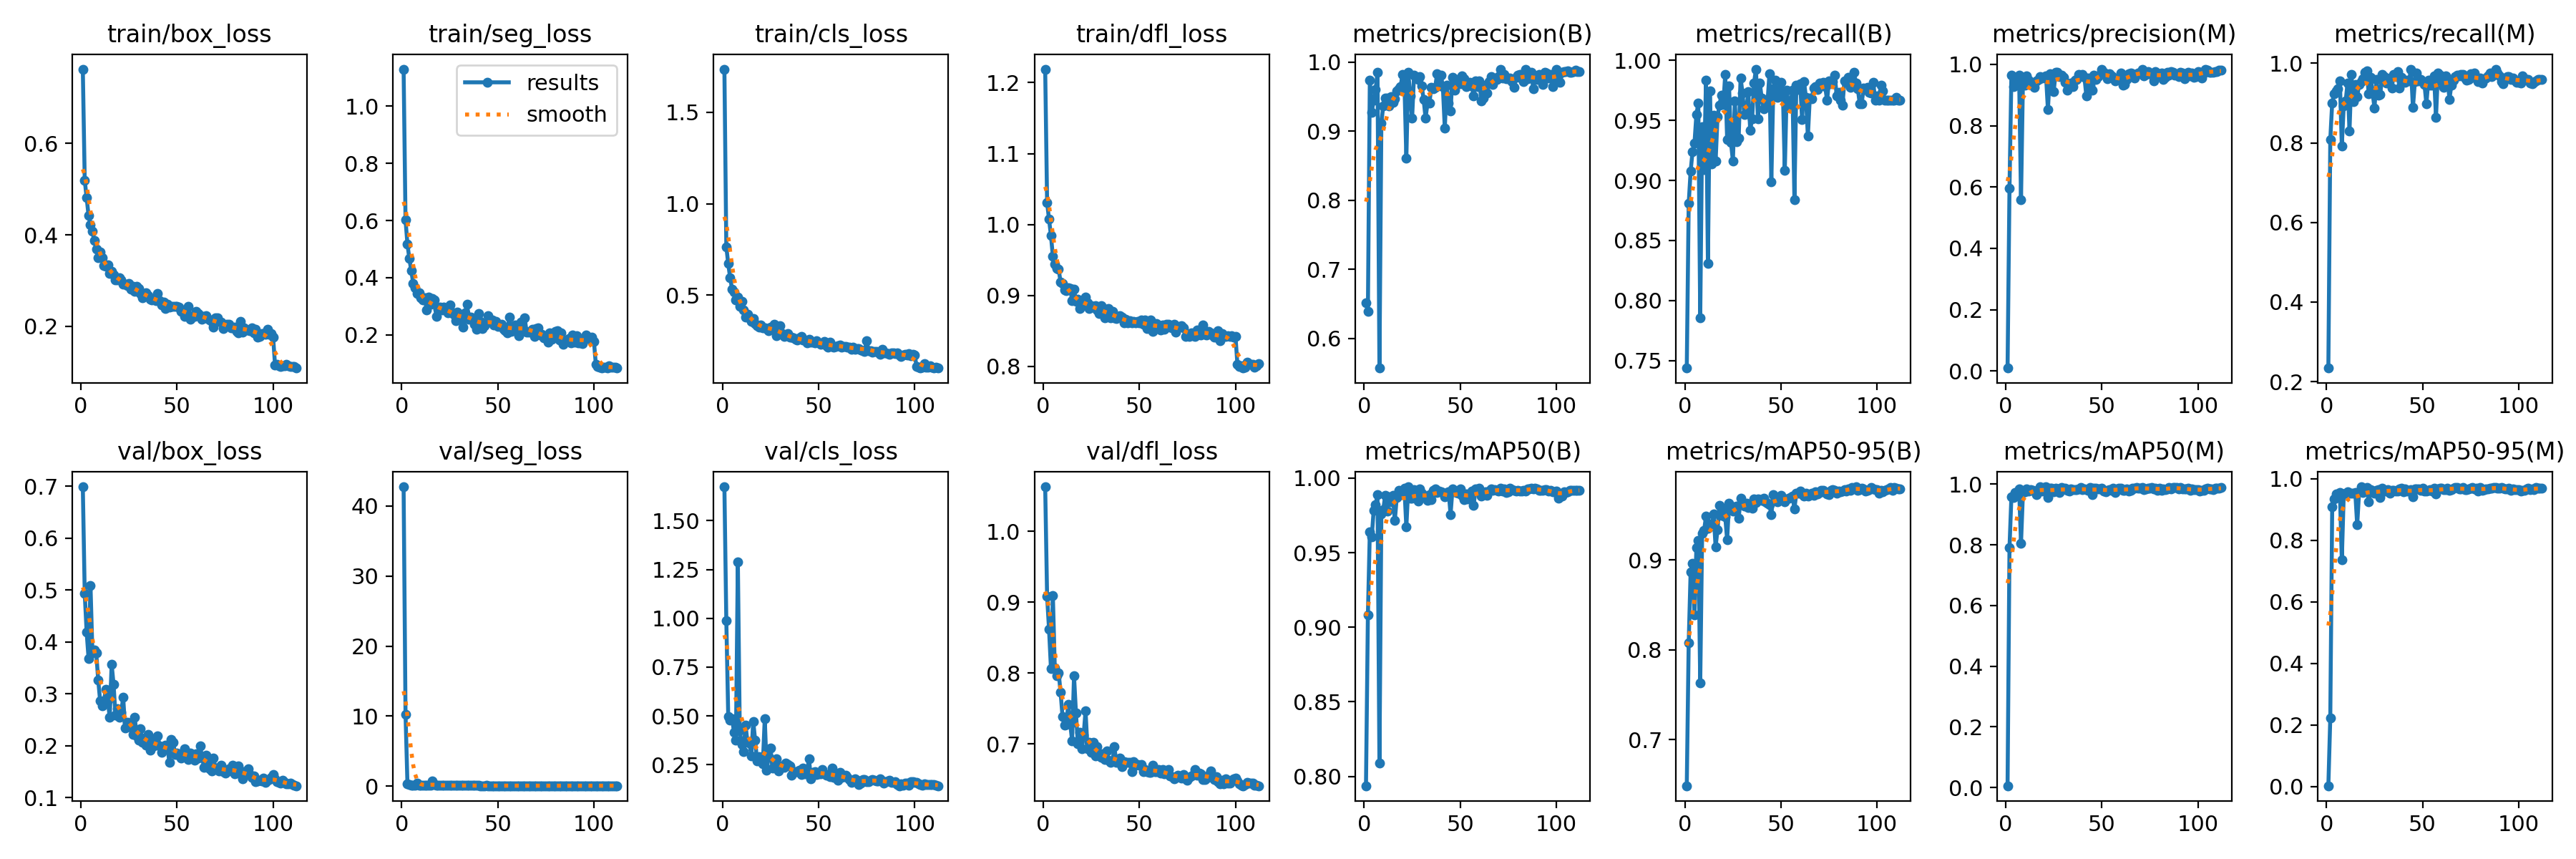


Validavimo painiavos matrica (confusion_matrix.png):


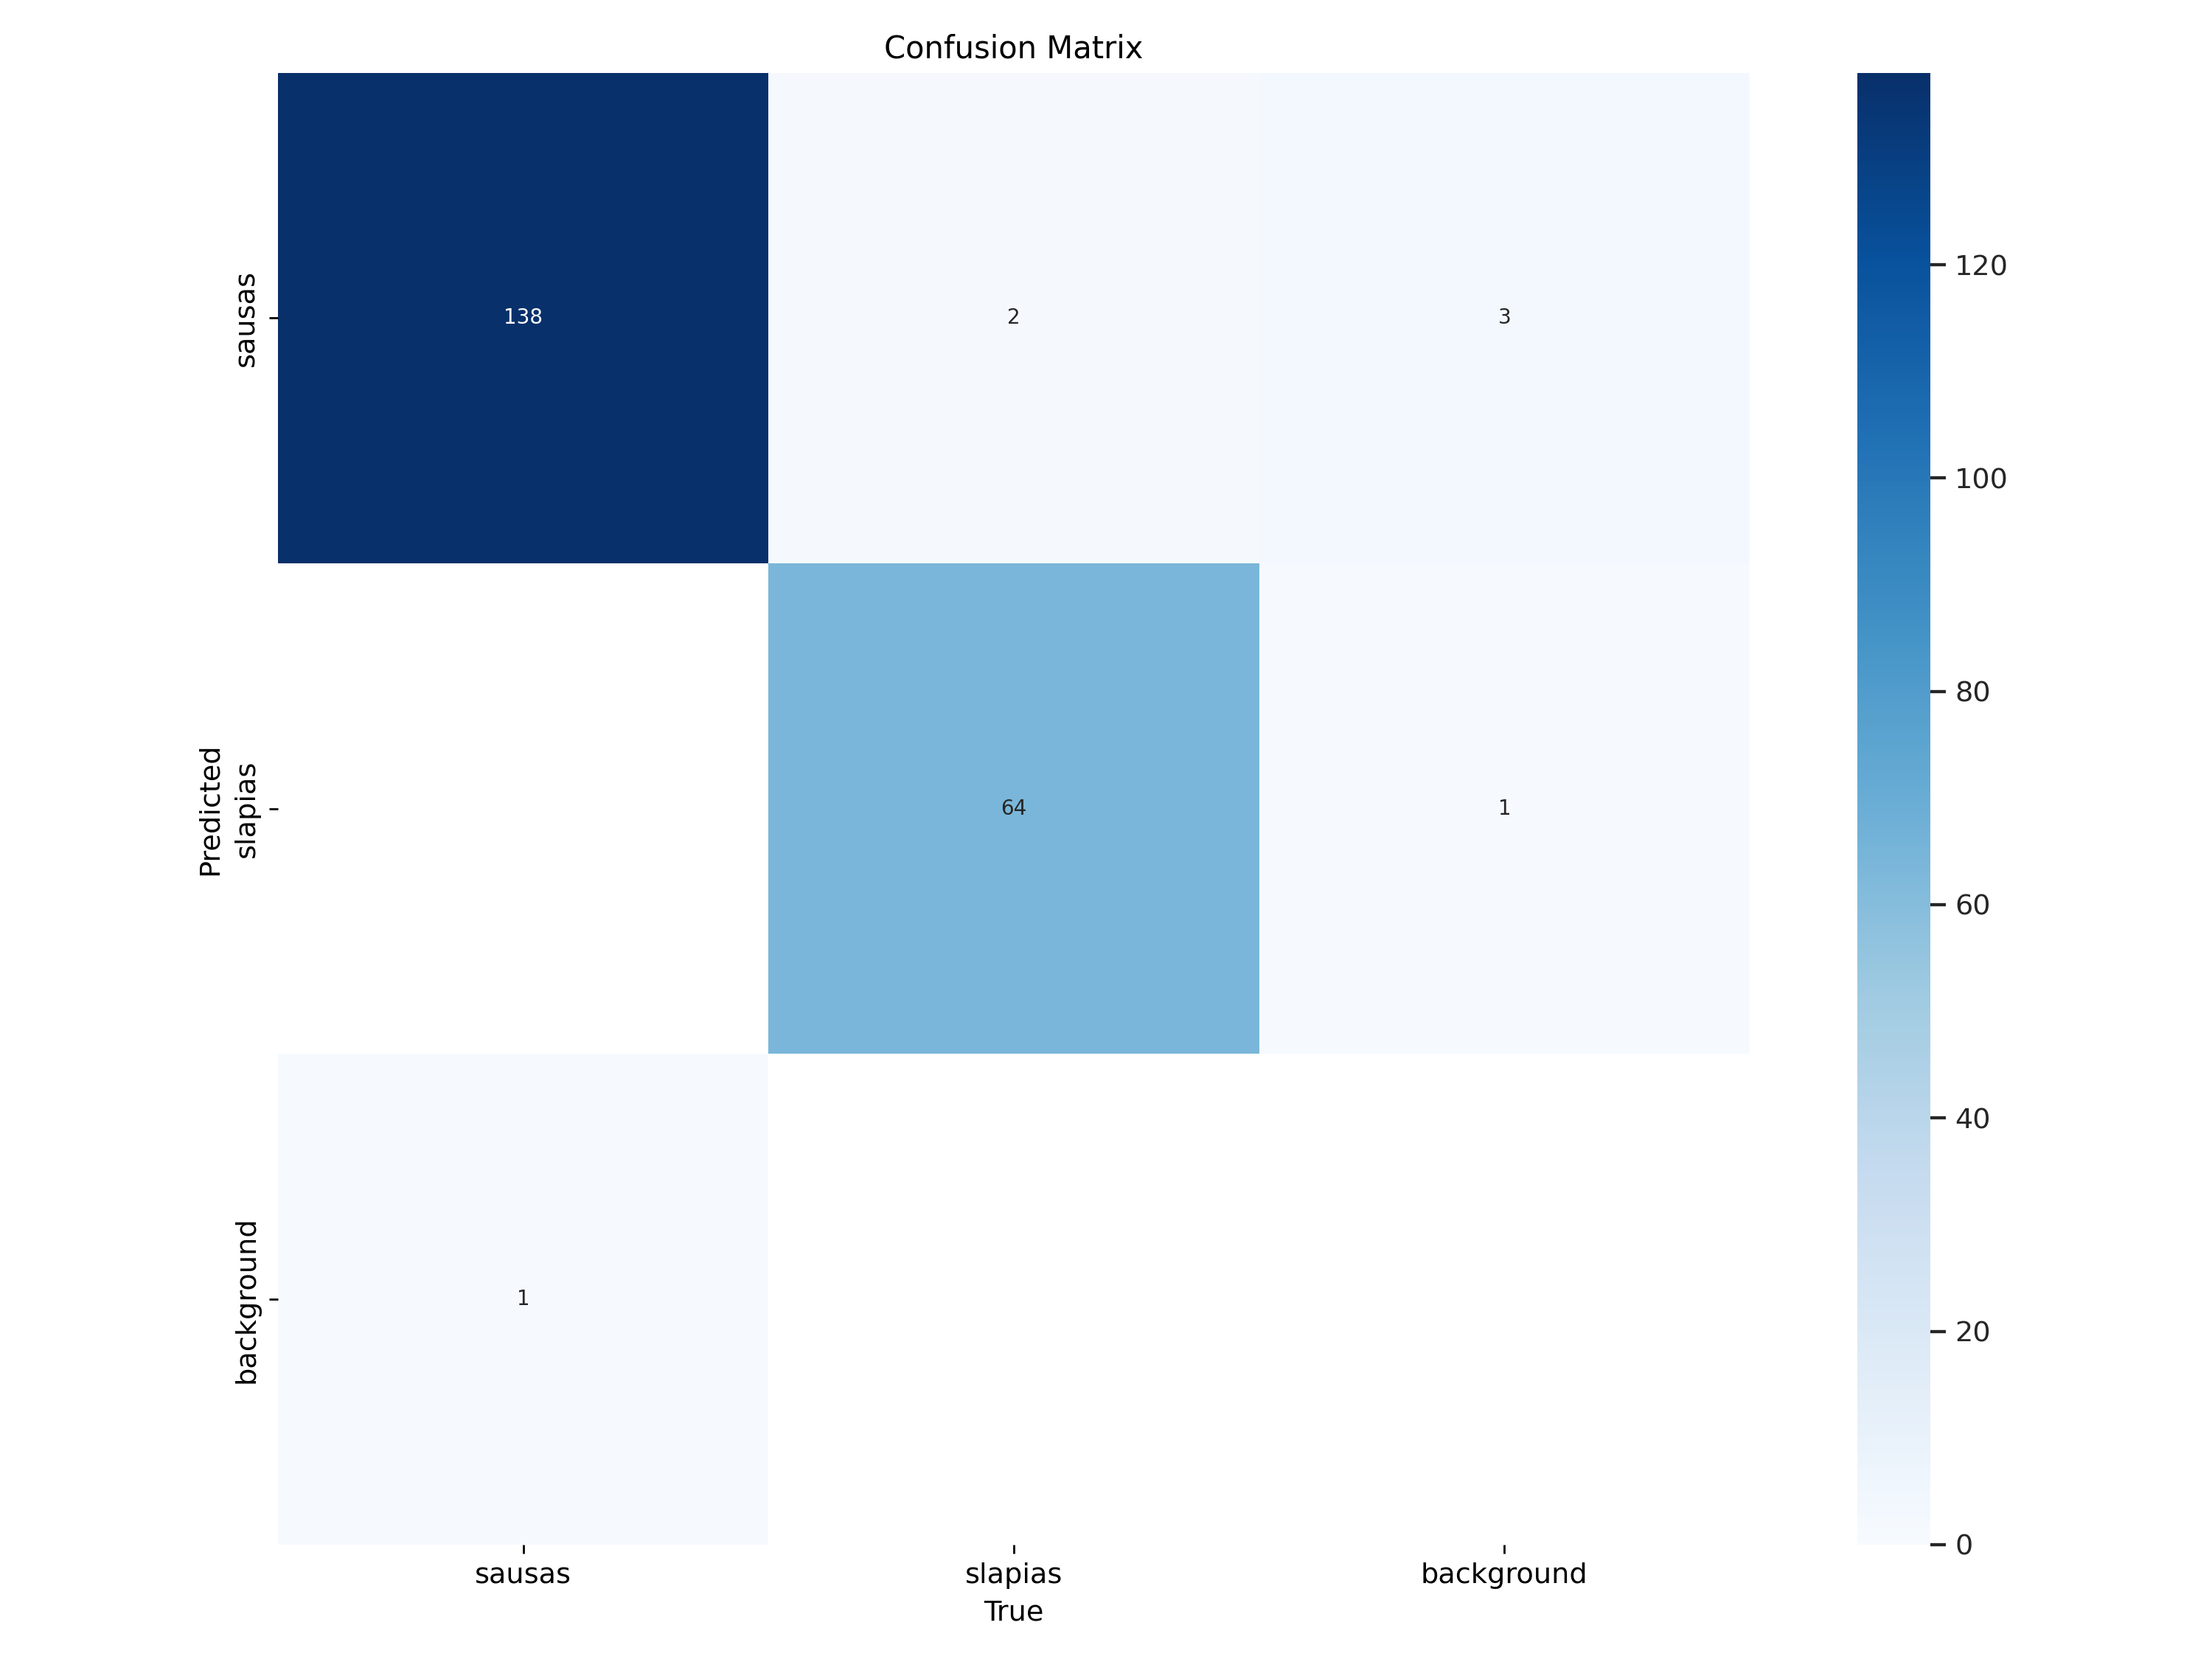

Training process finished successfully.


In [ ]:
#@title 6. Modelio mokymas su mazesniu learning rate
def train_road_wetness_model():
    """
    Mokome YOLOv8 segmentavimo modelį naudojant "Better" versijos parametrus
    ir išlaikant šio failo struktūrą.
    """
    # Nustatome bazinį žurnalo registravimą (iš "Worse" versijos)
    logging.basicConfig(level=logging.INFO,
                      format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger('train_export')

    print("\nRuošiame kelio drėgmės segmentavimo mokymą su 'Better' versijos parametrais...")
    logger.info("Pradedamas kelio drėgmės segmentavimo mokymas su 'Better' versijos parametrais")

    # Model loading logic from "Worse" version
    try:
        logger.info("Bandoma įkelti YOLOv8n-seg modelį...")
        model = YOLO('yolov8n-seg.pt')
        initial_model_name = 'yolov8n-seg'
        logger.info("Sėkmingai įkeltas YOLOv11n-seg modelis!")
    except Exception as e1:
        logger.warning(f"YOLOv11n-seg neprieinamas: {str(e1)}")
        try:
            logger.info("Bandoma įkelti YOLOv10n-seg modelį...")
            model = YOLO('yolov10n-seg.pt') # Try hypothetical v10
            initial_model_name = 'yolov10n-seg'
            logger.info("Sėkmingai įkeltas YOLOv10n-seg modelis!")
        except Exception as e2:
            logger.warning(f"YOLOv10n-seg neprieinamas: {str(e2)}")
            logger.info("Grįžtama prie YOLOv8n-seg modelio")
            try:
                model = YOLO('yolov8n-seg.pt') # Fallback to v8
                initial_model_name = 'yolov8n-seg'
                logger.info("Sėkmingai įkeltas YOLOv8n-seg modelis.")
            except Exception as e3:
                logger.error(f"Nepavyko įkelti jokio modelio (v11, v10, v8): {e3}")
                print(f"FATAL: Could not load any model (v11, v10, v8): {e3}")
                return None, None, None # Cannot continue without a model

    logger.info(f"Naudojamas modelis: {initial_model_name}")
    print(f"Naudojamas modelis: {initial_model_name}")

    # --- Training Parameters from "Better" version ---
    epochs = 120
    imgsz = 800 # From Better
    patience = 25
    batch_size = 12 # From Better

    lr0 = 0.0002 # From Better
    lrf = 0.005 # From Better
    weight_decay = 0.0005 # From Better
    warmup_epochs = 5.0
    dropout = 0.1
    save_period = 20 # From Better
    close_mosaic = 20 # From Better

    # Balanced augmentation configuration from "Better" version
    aug_params = {
        'hsv_h': 0.01,
        'hsv_s': 0.4,
        'hsv_v': 0.5,
        'degrees': 5.0,
        'translate': 0.1,
        'scale': 0.2,
        'fliplr': 0.5,
        'flipud': 0.0, # No vertical flip in Better version
        'mosaic': 0.4, # From Better
        'mixup': 0.1,  # From Better
    }
    # --- End of Training Parameters from "Better" version ---

    # Pradedame mokymą
    device_to_use = 0 if torch.cuda.is_available() else 'cpu'
    print(f"\nPradedame mokymą ant {device_to_use}")
    print(f"Vaizdo dydis: {imgsz}, Partijos dydis: {batch_size}, Epochos: {epochs}")
    print(f"Naudojamas svertinis duomenų įkėlėjas.") # Weighted dataloader is active
    print(f"Naudojami mokymo parametrai iš 'Better' versijos.")

    logger.info(f"Pradedamas mokymas su {initial_model_name} modeliu")
    logger.info(f"Naudojamas įrenginys: {device_to_use}")
    logger.info(f"Parametrai: imgsz={imgsz}, batch={batch_size}, epochs={epochs}, lr0={lr0}, weight_decay={weight_decay}")
    logger.info(f"Augmentacijos parametrai (YOLO): {aug_params}")

    # Ensure directories exist (good practice from Worse version)
    for dir_path in [project_dir, results_dir, predictions_dir, exports_dir]:
         if not os.path.exists(dir_path):
            os.makedirs(dir_path, exist_ok=True)
            logger.info(f"Sukurta direktorija: {dir_path}")

    try:
        # --- model.train() call using "Better" version parameters ---
        results = model.train(
            data=dataset_yaml,       # Use the YAML created in Section 4
            epochs=epochs,
            imgsz=imgsz,
            batch=batch_size,
            patience=patience,
            save=True,
            project=project_dir,     # Save results under the main project dir
            name='road_wetness_model', # Subdirectory for this run
            save_period=save_period,
            pretrained=True,         # Start from pretrained weights
            optimizer='AdamW',
            lr0=lr0,
            lrf=lrf,
            weight_decay=weight_decay,
            warmup_epochs=warmup_epochs,
            augment=True,            # Enable YOLO augmentations
            device=device_to_use,
            plots=True,              # Generate plots
            cos_lr=True,             # Cosine LR scheduler
            verbose=True,            # Show progress (NO print suppression)
            task='segment',
            dropout=dropout,
            single_cls=False,        # Multi-class problem
            close_mosaic=close_mosaic, # Close mosaic augmentation after X epochs
            **aug_params             # Apply specific augmentation parameters
        )
        # --- End of model.train() call ---

        logger.info("Apmokymas baigtas!")
        print("Mokymas baigtas!")

    except Exception as e:
        logger.error(f"Klaida mokymo metu: {str(e)}")
        print(f"Klaida mokymo metu: {str(e)}")
        traceback.print_exc()
        return None, None, None

    # Palaukti momentą (iš "Worse" versijos - gali būti naudinga)
    time.sleep(2)

    # Find best model path
    best_model_path = os.path.join(project_dir, 'road_wetness_model', 'weights', 'best.pt')

    if not os.path.exists(best_model_path):
        logger.warning(f"Best model not found at default path: {best_model_path}")
        # Try to find any .pt model (logic from Worse version)
        potential_models = glob.glob(os.path.join(project_dir, 'road_wetness_model', 'weights', '*.pt'))
        if potential_models:
            # Sort by modification time? Or just take the first found? Let's take the latest.
            potential_models.sort(key=os.path.getmtime, reverse=True)
            best_model_path = potential_models[0]
            logger.info(f"Naudojamas rastas modelis: {best_model_path}")
            print(f"Naudojame alternatyvų modelį: {best_model_path}")
        else:
            logger.error("Nepavyko rasti apmokyto modelio.")
            print("Modelio failai nerasti. Negalime tęsti.")
            return None, results, None

    logger.info(f"Geriausias modelis: {best_model_path}")
    print(f"Geriausias modelis: {best_model_path}")

    # Load best model
    try:
        best_model = YOLO(best_model_path)
    except Exception as e:
        logger.error(f"Klaida įkeliant geriausią modelį: {str(e)}")
        print(f"Klaida įkeliant geriausią modelį: {str(e)}")
        return None, results, None

    # --- Validation using "Better" version parameters ---
    logger.info("\nVykdomas validavimas...")
    print("\nVykdome validavimą...")
    val_results = None # Initialize
    try:
        val_results = best_model.val(
            data=dataset_yaml,
            split='val',
            imgsz=imgsz,
            batch=batch_size, # Use training batch size or specify different? Better used training batch size.
            plots=True,
            save_json=True, # Keep potentially useful output
            save_txt=True,  # Keep potentially useful output
            project=results_dir, # Save validation results in the dedicated results dir
            name='validation',   # Subfolder for validation run
            task='segment',
            conf=0.35,         # Balanced confidence threshold from Better
            iou=0.45           # IOU threshold from Better
        )

        # Print main metrics from Better version
        if hasattr(val_results, 'seg') and val_results.seg is not None:
             map50 = getattr(val_results.seg, 'map50', 'N/A')
             map_val = getattr(val_results.seg, 'map', 'N/A') # map50-95
             print(f"Validavimo mAP50: {map50:.4f}" if isinstance(map50, float) else f"Validavimo mAP50: {map50}")
             print(f"Validavimo mAP50-95: {map_val:.4f}" if isinstance(map_val, float) else f"Validavimo mAP50-95: {map_val}")
             logger.info(f"Validavimo mAP50: {map50}, mAP50-95: {map_val}")
        else:
             print("Validavimo segmentavimo metrikos nerastos.")
             logger.warning("Validavimo segmentavimo metrikos nerastos.")

    except Exception as e:
        logger.error(f"Klaida validavimo metu: {str(e)}")
        print(f"Klaida validavimo metu: {str(e)}")
        # Continue anyway

    # --- Prediction testing using "Better" version approach ---
    print("\nVykdome testavimo prognozes su keliais slenksčiais...")
    logger.info("Vykdomos testavimo prognozės su keliais slenksčiais ir TTA")
    try:
        test_img_dir = os.path.join(dataset_root, 'images', 'test')
        all_test_files = os.listdir(test_img_dir)
        # Select a few diverse images if possible (logic adapted from Better)
        test_images_paths = []
        shadow_samples = [f for f in all_test_files if '_shadow' in f] # Check for augmented shadows if they exist in test (unlikely with current setup)
        wet_samples = [f for f in all_test_files if not any(s in f for s in ['_shadow', '_reflect', '_reflective'])] # Assuming base names are wet/dry
        # Let's just pick a few random test images
        num_test_samples = 5
        if len(all_test_files) > num_test_samples:
             test_images_sample = random.sample(all_test_files, num_test_samples)
        else:
             test_images_sample = all_test_files

        test_images_paths = [os.path.join(test_img_dir, f) for f in test_images_sample]
        print(f"Testavimui pasirinkti vaizdai: {test_images_sample}")

        # Run predictions with multiple thresholds
        thresholds = [0.15, 0.25, 0.35, 0.45] # From Better

        for img_path in test_images_paths:
            if not os.path.exists(img_path):
                logger.warning(f"Testavimo vaizdas nerastas: {img_path}")
                continue
            img_name = os.path.basename(img_path)
            logger.info(f"Vykdoma prognozė vaizdui: {img_name}")

            for thresh in thresholds:
                pred_results = best_model.predict(
                    source=img_path,
                    save=True,
                    project=predictions_dir,
                    name=f"pred_{os.path.splitext(img_name)[0]}_thresh_{int(thresh*100)}",
                    conf=thresh,       # Current threshold
                    task='segment',
                    imgsz=imgsz,       # Specify imgsz for prediction
                    show=False,
                    save_txt=True,     # Save predicted labels
                    save_conf=True,    # Save confidences in txt files
                    boxes=True,        # Ensure boxes are saved/drawn
                    retina_masks=True, # Use high-res masks
                    line_width=2
                )
                logger.info(f"  Prognozė baigta: {img_name} (slenkstis {thresh})")

            # Also run one test with test-time augmentation (TTA) from Better
            logger.info(f"Vykdoma prognozė su TTA: {img_name}")
            pred_results_tta = best_model.predict(
                source=img_path,
                save=True,
                project=predictions_dir,
                name=f"pred_{os.path.splitext(img_name)[0]}_tta",
                conf=0.25,      # Balanced threshold for TTA (from Better)
                task='segment',
                imgsz=imgsz,    # Specify imgsz for prediction
                show=False,
                save_txt=True,
                save_conf=True,
                boxes=True,
                retina_masks=True,
                line_width=2,
                augment=True    # Enable test-time augmentation
            )
            logger.info(f"  Prognozė su TTA baigta: {img_name}")

    except Exception as e:
        logger.error(f"Klaida prognozės testavimo metu: {str(e)}")
        print(f"Klaida prognozės testavimo metu: {str(e)}")
    # --- End of Prediction testing ---


    # --- Exporting using "Better" version formats (PT, ONNX, TFLite) ---
    print("\nEksportuojame modelius (PT, ONNX, TFLite)...")
    logger.info("Eksportuojami modeliai PT, ONNX, TFLite formatais")
    export_success = {'pt': False, 'onnx': False, 'tflite': False}

    # Define export paths
    model_base_name = f"road_wetness_seg_{initial_model_name}" # Base name for exports
    pt_path = os.path.join(exports_dir, f'{model_base_name}.pt')
    onnx_path = os.path.join(exports_dir, f'{model_base_name}.onnx')


    try:
        # 1. Copy PT model
        shutil.copy(best_model_path, pt_path)
        logger.info(f"PyTorch modelis nukopijuotas į: {pt_path}")
        print(f"PyTorch modelis nukopijuotas į: {pt_path}")
        export_success['pt'] = True

        # 2. Export to ONNX (simpler export call from Better)
        logger.info("Eksportuojama į ONNX formatą...")
        print("Eksportuojama į ONNX formatą...")
        # The export function saves the file in the same directory as the model by default
        onnx_export_result_path = best_model.export(format='onnx', imgsz=imgsz, simplify=True)
        # onnx_export_result_path might be None or the actual path
        # Let's find the expected default path
        default_onnx_name = os.path.splitext(best_model_path)[0] + '.onnx'

        if os.path.exists(default_onnx_name):
             shutil.move(default_onnx_name, onnx_path) # Move it to exports dir
             logger.info(f"ONNX modelis eksportuotas ir perkeltas į: {onnx_path}")
             print(f"ONNX modelis eksportuotas ir perkeltas į: {onnx_path}")
             export_success['onnx'] = True
        elif onnx_export_result_path and os.path.exists(onnx_export_result_path):
             # If export returned a path and it exists
             shutil.move(onnx_export_result_path, onnx_path)
             logger.info(f"ONNX modelis eksportuotas (iš {onnx_export_result_path}) ir perkeltas į: {onnx_path}")
             print(f"ONNX modelis eksportuotas (iš {onnx_export_result_path}) ir perkeltas į: {onnx_path}")
             export_success['onnx'] = True
        else:
             logger.error("ONNX eksportavimas baigtas, bet failas nerastas.")
             print("ONNX eksportavimas baigtas, bet failas nerastas.")

    except Exception as e:
        logger.error(f"Klaida modelio eksportavimo metu: {str(e)}")
        print(f"Klaida modelio eksportavimo metu: {str(e)}")
        traceback.print_exc()
    # --- End of Exporting ---


    # Training results (using 'results' object)
    print("\nMokymo Rezultatai:")
    if hasattr(results, 'metrics') and results.metrics:
         final_fitness = results.metrics.get('fitness', 'N/A')
         print(f"  Galutinis tinkamumo balas (fitness): {final_fitness:.4f}" if isinstance(final_fitness, float) else f"  Galutinis tinkamumo balas (fitness): {final_fitness}")
         # You can access other metrics like mAP, precision, recall from results.metrics if needed

    # Validation results (using 'val_results' object)
    print("\nValidavimo Rezultatai:")
    if val_results and hasattr(val_results, 'seg'):
         map50 = getattr(val_results.seg, 'map50', 'N/A')
         map_val = getattr(val_results.seg, 'map', 'N/A')
         print(f"  Validavimo mAP50: {map50:.4f}" if isinstance(map50, float) else f"  Validavimo mAP50: {map50}")
         print(f"  Validavimo mAP50-95: {map_val:.4f}" if isinstance(map_val, float) else f"  Validavimo mAP50-95: {map_val}")
    else:
        print("  Validavimo metrikos negautos arba nepavyko.")

    # Export information
    print("\nEksportuoti modeliai:")
    print(f"  PyTorch (.pt): {pt_path if export_success['pt'] else 'Nepavyko'}")
    print(f"  ONNX (.onnx): {onnx_path if export_success['onnx'] else 'Nepavyko'}")
    print("\nRezultatai išsaugoti:")
    print(f"  Projekto direktorija: {project_dir}")
    print(f"  Mokymo eiga/grafikai: {os.path.join(project_dir, 'road_wetness_model')}")
    print(f"  Validavimo rezultatai: {os.path.join(results_dir, 'validation')}")
    print(f"  Prognozių pavyzdžiai: {predictions_dir}")
    print(f"  Eksportuoti modeliai: {exports_dir}")
    print("="*70)

    # Display results plots (if available)
    try:
        results_png_path = os.path.join(project_dir, 'road_wetness_model', 'results.png')
        confusion_matrix_path = os.path.join(results_dir, 'validation', 'confusion_matrix.png') # From val run

        if os.path.exists(results_png_path):
            print("\nMokymo rezultatai (results.png):")
            display(Image(results_png_path))
        if os.path.exists(confusion_matrix_path):
            print("\nValidavimo painiavos matrica (confusion_matrix.png):")
            display(Image(confusion_matrix_path))

    except Exception as e:
        logger.warning(f"Nepavyko parodyti rezultatų grafikų: {e}")
        # Pass silently if display fails

    return best_model, results, val_results
# --- End of train_road_wetness_model function ---

# Vykdyti mokymo funkciją
if __name__ == "__main__":
    # Set random seed for reproducibility where possible (add near start)
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
        # Consider adding these for more determinism, but they can impact performance
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

    print("Starting training process...")
    model, train_res, val_res = train_road_wetness_model()
    if model:
        print("Training process finished successfully.")
    else:
        print("Training process encountered an error.")


In [ ]:
#@title 2. Projekto struktūros konfigūravimas

# Base directories for road wetness segmentation
base_dir = '/content/drive/MyDrive/Dangos Dregmes Nustatymas'
print(f"Pagrindinis katalogas: {base_dir}")

# Source directories for masked images and labels
images_dir = os.path.join(base_dir, 'Images(kaukes)')
labels_dirs = {
    'sausas': os.path.join(base_dir, 'labels2', 'Sausas'),   # klasė 3 konvertuojama į 0
    'slapias': os.path.join(base_dir, 'labels2', 'Slapias')  # klasė 4 konvertuojama į 1
}

# Sukuriame laiko žymą unikaliam projekto paleidimui
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
project_dir = os.path.join(base_dir, f'road_wetness_seg_{timestamp}')
os.makedirs(project_dir, exist_ok=True)

# Rezultatų katalogai
results_dir = os.path.join(project_dir, 'results')
predictions_dir = os.path.join(project_dir, 'predictions')
exports_dir = os.path.join(project_dir, 'exports')
os.makedirs(results_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)
os.makedirs(exports_dir, exist_ok=True)

# Sukuriame duomenų rinkinio katalogų struktūrą
dataset_root = os.path.join(base_dir, f'road_wetness_dataset_{timestamp}')
os.makedirs(dataset_root, exist_ok=True)

# Sukuriame YOLO duomenų rinkinio struktūrą
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_root, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(dataset_root, 'labels', split), exist_ok=True)



Pagrindinis katalogas: /content/drive/MyDrive/Dangos Dregmes Nustatymas


In [ ]:
#@title 3. Duomenų rinkinio analizė ir padalijimų sukūrimas

def analyze_dataset():
    """Analizuoti duomenų rinkinį ir sukurti padalijimus"""
    # Gauname visus pažymėtus failus iš kiekvieno katalogo
    all_files = {}

    # Skaičiuojame failus kiekvienam drėgmės tipui
    type_counts = {}

    for wetness_type, label_dir in labels_dirs.items():
        files = []
        class_id = {"sausas": 0, "slapias": 1}[wetness_type]  # Konvertuojame 3,4 į 0,1

        # Gauname visus txt failus, išskyrus classes.txt
        for file in os.listdir(label_dir):
            if file.endswith('.txt') and file != 'classes.txt':
                base_name = os.path.splitext(file)[0]
                # Tikriname, ar egzistuoja atitinkamas vaizdas
                img_path = None
                for ext in ['.jpg', '.jpeg', '.png']:
                    if os.path.exists(os.path.join(images_dir, base_name + ext)):
                        img_path = os.path.join(images_dir, base_name + ext)
                        break

                if img_path:
                    files.append({
                        'base_name': base_name,
                        'img_path': img_path,
                        'label_path': os.path.join(label_dir, file),
                        'wetness_type': wetness_type,
                        'class_id': class_id # Use the target class ID (0 or 1)
                    })

        all_files[wetness_type] = files
        type_counts[wetness_type] = len(files)

    # Spausdiname statistiką
    print("\nDuomenų rinkinio statistika:")
    total_files = sum(type_counts.values())
    for wetness_type, count in type_counts.items():
        print(f"  {wetness_type}: {count} failai ({count/total_files*100:.1f}%)")
    print(f"  Iš viso: {total_files} failai")

    # Sukuriame padalijimus (70% train, 15% val, 15% test) - Using "Better" version's split logic
    splits = {'train': [], 'val': [], 'test': []}

    for wetness_type, files in all_files.items():
        # Padalijame failus
        train_files, temp = train_test_split(
            files, test_size=0.3, random_state=42
        )
        val_files, test_files = train_test_split(
            temp, test_size=0.5, random_state=42 # 0.3 * 0.5 = 0.15 for val and test
        )

        # Pridedame į padalijimus
        splits['train'].extend(train_files)
        splits['val'].extend(val_files)
        splits['test'].extend(test_files)

    # Spausdiname padalijimų statistiką
    print("\nPadalijimų statistika:")
    for split_name, files in splits.items():
        print(f"  {split_name}: {len(files)} failai")

        # Skaičiuojame pagal drėgmės tipą
        split_counts = {}
        for file in files:
            wt = file['wetness_type']
            split_counts[wt] = split_counts.get(wt, 0) + 1

        for wt, count in split_counts.items():
            print(f"    - {wt}: {count} failai ({count/len(files)*100:.1f}%)")

    return splits, type_counts

# Analizuojame duomenų rinkinį ir sukuriame padalijimus
splits, class_counts = analyze_dataset()


Duomenų rinkinio statistika:
  sausas: 711 failai (64.4%)
  slapias: 393 failai (35.6%)
  Iš viso: 1104 failai

Padalijimų statistika:
  train: 772 failai
    - sausas: 497 failai (64.4%)
    - slapias: 275 failai (35.6%)
  val: 166 failai
    - sausas: 107 failai (64.5%)
    - slapias: 59 failai (35.5%)
  test: 166 failai
    - sausas: 107 failai (64.5%)
    - slapias: 59 failai (35.5%)


In [ ]:
#@title 4. Duomenų rinkinio failų apdorojimas su tikslinėmis augmentacijomis (metodas su weights - dataset.yaml ir be monkey patching)

def process_dataset_files_with_weights():
    """Apdoroti duomenų rinkinio failus ir paruošti mokymui, taikant
    tikslinius augmentavimus ir įtraukiant svorius į dataset.yaml vietoj pasvertojo dataloader'io.
    """
    print("\nApdorojame duomenų rinkinio failus su tiksliniais augmentavimais...")

    # --- Augmentation definitions remain the same ---
    # Shadow augmentation
    shadow_aug = A.Compose([
        A.RandomShadow(shadow_roi=(0, 0, 1, 1), p=0.9),
        A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.1), contrast_limit=(-0.1, 0.2), p=0.7),
    ])
    # Reflection simulation augmentation
    reflection_aug = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.3), contrast_limit=(0.1, 0.5), p=0.8),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.6),
    ])

    # Enhancement functions remain the same
    def enhance_reflection_features(image):
        """Enhance the visibility of reflective areas using contrast methods"""
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        enhanced_lab = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        alpha = 1.15
        beta = 5
        enhanced = cv2.convertScaleAbs(enhanced, alpha=alpha, beta=beta)
        return enhanced

    def simulate_reflections(image):
        """Add simulated reflections similar to those seen on wet road surfaces"""
        # Function implementation remains the same
        height, width = image.shape[:2]
        reflection_map = np.zeros_like(image, dtype=np.float32)

        gradient = np.linspace(0, 1, height)[:, np.newaxis, np.newaxis]
        gradient = np.tile(gradient, (1, width, 3))
        gradient = gradient * np.clip(np.random.normal(0.5, 0.2), 0.3, 0.7)

        num_patterns = random.randint(3, 7)
        for _ in range(num_patterns):
            center_x = random.randint(width//4, 3*width//4)
            center_y = random.randint(height//2, 4*height//5)
            rx = random.randint(20, width//4)
            ry = random.randint(10, height//8)
            y, x = np.ogrid[:height, :width]
            dist = ((x - center_x) / rx) ** 2 + ((y - center_y) / ry) ** 2
            mask = dist <= 1
            effect = np.ones_like(image, dtype=np.float32) * 0.7
            reflection_map[mask] = np.maximum(reflection_map[mask], effect[mask])

        reflection_strength = 0.3
        reflection = cv2.addWeighted(
            image, 1.0,
            cv2.GaussianBlur(image, (7, 7), 0), reflection_strength,
            0
        )

        result = image.copy().astype(np.float32)
        for i in range(3):
            result[:,:,i] = (1 - reflection_map[:,:,i] * gradient[:,:,i]) * image[:,:,i] + \
                           (reflection_map[:,:,i] * gradient[:,:,i]) * reflection[:,:,i]

        return np.clip(result, 0, 255).astype(np.uint8)

    # Class mapping remains the same
    class_id_map = {"sausas": 0, "slapias": 1}
    original_class_ids = {"sausas": 3, "slapias": 4}

    # Helper function remains the same
    def copy_modify_label(src_label_path, dst_label_path, wetness_type):
        """Nukopijuoti žymių failą, pakeičiant klasės ID iš originalaus į tikslinį."""
        original_id = original_class_ids[wetness_type]
        target_class_id = class_id_map[wetness_type]

        try:
            with open(src_label_path, 'r') as src_file:
                lines = src_file.readlines()

            modified_content = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    current_class = int(parts[0])
                    if current_class == original_id:
                        parts[0] = str(target_class_id)
                        modified_content.append(' '.join(parts))

            if modified_content:
                 with open(dst_label_path, 'w') as dst_file:
                    dst_file.write('\n'.join(modified_content))

        except Exception as e:
            print(f"Error processing label {src_label_path} to {dst_label_path}: {e}")

    # Counter for augmented samples
    augmented_samples = {'train': 0, 'val': 0, 'test': 0}

    # Process files - same as before
    for split, files in splits.items():
        for file_data in tqdm(files, desc=f"Apdorojame {split} rinkinį"):
            img_path = file_data['img_path']
            label_path = file_data['label_path']
            base_name = file_data['base_name']
            class_id = file_data['class_id']
            wetness_type = file_data['wetness_type']

            dest_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}.jpg")
            dest_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}.txt")

            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            processed_img = img.copy()
            if class_id == 1:  # Wet road class
                processed_img = enhance_reflection_features(processed_img)

            cv2.imwrite(dest_img_path, processed_img)
            copy_modify_label(label_path, dest_label_path, wetness_type)

            # Augmentations for training set only - same as before
            if split == 'train':
                if class_id == 1: # Wet road
                    if random.random() < 0.7:
                        reflection_img = simulate_reflections(processed_img)
                        reflection_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_reflect.jpg")
                        reflection_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_reflect.txt")
                        cv2.imwrite(reflection_img_path, reflection_img)
                        copy_modify_label(label_path, reflection_label_path, wetness_type)
                        augmented_samples[split] += 1

                        reflective_img = reflection_aug(image=processed_img)['image']
                        reflective_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_reflective.jpg")
                        reflective_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_reflective.txt")
                        cv2.imwrite(reflective_img_path, reflective_img)
                        copy_modify_label(label_path, reflective_label_path, wetness_type)
                        augmented_samples[split] += 1

                elif class_id == 0: # Dry road
                     if random.random() < 0.8:
                        shadow_img = shadow_aug(image=img)['image']
                        shadow_img_path = os.path.join(dataset_root, 'images', split, f"{base_name}_shadow.jpg")
                        shadow_label_path = os.path.join(dataset_root, 'labels', split, f"{base_name}_shadow.txt")
                        cv2.imwrite(shadow_img_path, shadow_img)
                        copy_modify_label(label_path, shadow_label_path, wetness_type)
                        augmented_samples[split] += 1

    # Print augmentation statistics - same as before
    print("\nAugmentation statistics:")
    for split_name, count in augmented_samples.items():
        if count > 0:
            print(f"  Pridėta {count} augmentuotų pavyzdžių į {split_name} rinkinį")

    total_augmented = sum(augmented_samples.values())
    print(f"  Iš viso augmentuotų pavyzdžių: {total_augmented}")

    original_total = sum(len(files) for files in splits.values())
    final_total = original_total + total_augmented
    print(f"  Galutinis duomenų rinkinio dydis: {final_total} vaizdai")

    # Calculate weights for classes to use in dataset.yaml
    # Use inverse class frequency weighting similar to the weighted dataloader
    class_weights = {}
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)

    for wetness_type, count in class_counts.items():
        if count > 0:
            # Inverse frequency weighting
            class_weights[class_id_map[wetness_type]] = total_samples / (num_classes * count)
        else:
            class_weights[class_id_map[wetness_type]] = 1.0

    # Normalize weights to sum to 1.0 for YAML format
    weight_sum = sum(class_weights.values())
    if weight_sum > 0:
        for k in class_weights:
            class_weights[k] = class_weights[k] / weight_sum

    # Round for display
    formatted_weights = {k: round(v, 4) for k, v in class_weights.items()}
    print(f"\nCalculated class weights for dataset.yaml: {formatted_weights}")

    # Create dataset.yaml with class weights
    dataset_yaml = os.path.join(dataset_root, 'dataset.yaml')
    yaml_content = {
        'path': dataset_root,
        'train': os.path.join('images', 'train'),
        'val': os.path.join('images', 'val'),
        'test': os.path.join('images', 'test'),
        'names': {0: 'sausas', 1: 'slapias'},
        'nc': 2,
        'weights': list(class_weights.values())  # Add class weights to YAML
    }

    with open(dataset_yaml, 'w') as f:
        yaml.dump(yaml_content, f)

    print(f"\nDuomenų rinkinio konfigūracija su svoriais sukurta: {dataset_yaml}")
    print("Dataset structure created with originals + targeted augmented samples.")

    return dataset_yaml

# Replace the previous process_dataset_files_better_aug function with this updated version
dataset_yaml = process_dataset_files_with_weights()


Apdorojame duomenų rinkinio failus su tiksliniais augmentavimais...


Apdorojame test rinkinį: 100%|██████████| 166/166 [03:50<00:00,  1.39s/it]


Augmentation statistics:
  Pridėta 777 augmentuotų pavyzdžių į train rinkinį
  Iš viso augmentuotų pavyzdžių: 777
  Galutinis duomenų rinkinio dydis: 1881 vaizdai

Calculated class weights for dataset.yaml: {0: 0.356, 1: 0.644}

Duomenų rinkinio konfigūracija su svoriais sukurta: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/dataset.yaml
Dataset structure created with originals + targeted augmented samples.


Starting training process...

Ruošiame kelio drėgmės segmentavimo mokymą su 'Better' versijos parametrais...


100%|██████████| 6.74M/6.74M [00:00<00:00, 129MB/s]


Naudojamas modelis: yolov8n-seg

Pradedame mokymą ant 0
Vaizdo dydis: 800, Partijos dydis: 12, Epochos: 120
Naudojamas svertinis duomenų įkėlėjas.
Naudojami mokymo parametrai iš 'Better' versijos.
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/dataset.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.4, hsv_v=0.5, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0002, lrf=0.005, mask_rat

100%|██████████| 755k/755k [00:00<00:00, 27.1MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                


  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384,

100%|██████████| 5.35M/5.35M [00:00<00:00, 122MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.0 ms, read: 165.7±67.4 MB/s, size: 683.5 KB)


train: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/train... 1549 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1549/1549 [00:23<00:00, 64.58it/s] 


train: New cache created: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ val: Slow image access detected (ping: 31.4±58.7 ms, read: 58.4±68.9 MB/s, size: 748.8 KB). Use local storage instead of remote/mounted storage for better performance. See https://docs.ultralytics.com/guides/model-training-tips/


val: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/val... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:02<00:00, 74.61it/s] 


val: New cache created: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/val.cache
Plotting labels to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/labels.jpg... 
optimizer: AdamW(lr=0.0002, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.00046875), 76 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/120      3.07G     0.7627      1.129      1.737      1.219          1        800: 100%|██████████| 130/130 [02:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]

                   all        166        205      0.652      0.744      0.794      0.649    0.00958      0.234    0.00596    0.00215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/120      3.44G     0.5195     0.6016     0.7634      1.031          6        800: 100%|██████████| 130/130 [02:14<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]

                   all        166        205      0.639      0.881      0.908      0.808      0.596      0.808       0.79      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/120      3.46G      0.481     0.5171     0.6722      1.007          3        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]

                   all        166        205      0.974      0.908      0.964      0.886      0.965      0.901       0.96      0.909



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/120      3.46G     0.4421     0.4662     0.5929     0.9844          3        800: 100%|██████████| 130/130 [02:29<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        166        205      0.928      0.924       0.96      0.896      0.928      0.924      0.957      0.935



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/120      3.49G     0.4215     0.4236     0.5331     0.9552          1        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.40s/it]

                   all        166        205      0.945      0.931      0.978      0.839      0.945      0.931      0.974      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/120      3.51G     0.4075     0.3808     0.5164     0.9445          3        800: 100%|██████████| 130/130 [02:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]

                   all        166        205       0.96      0.955      0.982      0.914      0.945      0.935      0.972       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/120      3.53G     0.3871     0.3646     0.4751     0.9379          1        800: 100%|██████████| 130/130 [02:58<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:28<00:00,  4.13s/it]

                   all        166        205      0.985      0.964      0.989      0.922      0.964      0.956      0.984      0.955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/120      3.55G     0.3682     0.3445     0.4908     0.9369          1        800: 100%|██████████| 130/130 [03:20<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:17<00:00,  2.48s/it]

                   all        166        205      0.557      0.785      0.809      0.764      0.558      0.793      0.805      0.736



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/120      3.57G     0.3499     0.3478     0.4361     0.9192          1        800: 100%|██████████| 130/130 [02:34<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.14s/it]

                   all        166        205      0.912      0.945      0.976       0.93      0.948      0.893      0.972       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/120      3.59G     0.3623       0.33     0.4669     0.9171          1        800: 100%|██████████| 130/130 [02:17<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.94s/it]

                   all        166        205      0.937      0.909      0.979      0.933      0.933      0.905      0.975      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/120      3.61G     0.3502      0.323     0.4178     0.9076          1        800: 100%|██████████| 130/130 [04:50<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:34<00:00,  4.99s/it]

                   all        166        205      0.948      0.984      0.989      0.948      0.961      0.951      0.984      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/120      3.62G     0.3325     0.3297     0.3799     0.9072          1        800: 100%|██████████| 130/130 [06:02<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:29<00:00,  4.26s/it]

                   all        166        205      0.948      0.831      0.978      0.935      0.948      0.831      0.976      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/120      3.64G     0.3309     0.2881     0.3968     0.9107          1        800: 100%|██████████| 130/130 [04:48<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:30<00:00,  4.43s/it]

                   all        166        205      0.937      0.975      0.988       0.94      0.933      0.971      0.982      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/120      3.66G     0.3347      0.332     0.3755     0.9099          1        800: 100%|██████████| 130/130 [02:28<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        166        205       0.95      0.914      0.984      0.939      0.938      0.904       0.98      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/120      3.68G     0.3151     0.3061     0.3547     0.8931          3        800: 100%|██████████| 130/130 [02:06<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

                   all        166        205      0.942      0.955      0.988      0.951      0.926      0.946      0.978      0.956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/120       3.7G     0.3209      0.327     0.3726     0.9086          7        800: 100%|██████████| 130/130 [02:12<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        166        205      0.946      0.916      0.971      0.915      0.946      0.916      0.967       0.85



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/120      3.72G      0.312     0.3226     0.3425     0.8919          3        800: 100%|██████████| 130/130 [02:07<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        166        205      0.958      0.953      0.987      0.934      0.952      0.946      0.983      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/120      3.74G     0.3016     0.2643     0.3341     0.8948          1        800: 100%|██████████| 130/130 [02:08<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.87s/it]

                   all        166        205      0.961      0.963      0.992      0.961      0.961      0.953      0.991      0.974



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/120      3.75G     0.3017     0.2894      0.326      0.882          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]

                   all        166        205      0.964      0.971      0.989      0.949      0.956       0.96      0.977      0.955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/120      3.77G     0.3063     0.2963     0.3351     0.8904          2        800: 100%|██████████| 130/130 [02:30<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]

                   all        166        205      0.982      0.963      0.989      0.956      0.959      0.978      0.988      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/120      3.79G     0.3021     0.2877     0.3205     0.8868          2        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]

                   all        166        205       0.97      0.988      0.993      0.948      0.963      0.981      0.991      0.973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/120      3.81G     0.2929     0.2968     0.3198     0.8973          1        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.62s/it]

                   all        166        205      0.861      0.934      0.967      0.922      0.853      0.923      0.956      0.926



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/120      3.83G     0.2924     0.2877     0.3169     0.8899          1        800: 100%|██████████| 130/130 [02:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        166        205      0.985      0.979      0.994      0.963       0.97      0.964      0.986      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/120      3.85G     0.2894     0.2776     0.3039     0.8819          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        166        205      0.951      0.932      0.987      0.957      0.947      0.926      0.986       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/120      3.87G     0.2935     0.3049     0.3257     0.8857          4        800: 100%|██████████| 130/130 [02:12<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        166        205      0.918      0.916      0.986      0.954      0.911      0.888      0.975      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/120      3.88G     0.2809     0.2786     0.3212     0.8832          4        800: 100%|██████████| 130/130 [02:17<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        166        205      0.981      0.966      0.992      0.959      0.974      0.959      0.986      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/120       3.9G     0.2875     0.2712     0.3402     0.8859          2        800: 100%|██████████| 130/130 [02:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.34s/it]

                   all        166        205      0.977      0.932      0.988       0.96      0.974      0.919      0.984      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/120      3.92G     0.2759     0.2506     0.2792     0.8793          3        800: 100%|██████████| 130/130 [02:06<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]

                   all        166        205      0.974      0.936      0.984      0.946       0.96      0.922      0.972      0.938



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/120      3.94G     0.2881     0.2796     0.2874     0.8748          2        800: 100%|██████████| 130/130 [02:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.36s/it]

                   all        166        205      0.979      0.986      0.993      0.969      0.965      0.971      0.989       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/120      3.96G     0.2823     0.2642     0.3336     0.8858          1        800: 100%|██████████| 130/130 [02:07<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        166        205      0.965      0.973       0.99      0.963      0.958      0.966      0.985      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/120      3.98G     0.2719     0.2571     0.2874     0.8776          1        800: 100%|██████████| 130/130 [02:01<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.40s/it]

                   all        166        205      0.946      0.955      0.987       0.96      0.942      0.951      0.986      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/120      3.99G     0.2627     0.2262     0.2715     0.8681          1        800: 100%|██████████| 130/130 [02:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.01s/it]

                   all        166        205      0.919       0.96      0.988      0.963      0.916      0.951       0.98      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/120      4.01G     0.2714     0.2766     0.2824     0.8807          2        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

                   all        166        205       0.94      0.974      0.985      0.958       0.93      0.963      0.977      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/120      4.03G     0.2739     0.3074     0.2872     0.8819          1        800: 100%|██████████| 130/130 [02:26<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.09s/it]

                   all        166        205       0.94      0.942      0.989      0.962      0.938      0.938      0.985      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/120      4.05G     0.2668     0.2551     0.2688     0.8687          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.22s/it]

                   all        166        205      0.964      0.952      0.986      0.958      0.928      0.972      0.981      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/120      4.07G     0.2594     0.2618     0.2691     0.8778          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.33s/it]

                   all        166        205      0.962      0.981      0.992      0.968      0.948      0.966      0.982      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/120      4.09G      0.258     0.2557     0.2649     0.8685          1        800: 100%|██████████| 130/130 [03:54<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]

                   all        166        205      0.964      0.993      0.993      0.964       0.95      0.978      0.981      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/120      4.11G     0.2592     0.2362     0.2563     0.8679          2        800: 100%|██████████| 130/130 [02:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]

                   all        166        205      0.983      0.952       0.99      0.968      0.968      0.937      0.985      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/120      4.12G     0.2558     0.2185     0.2523     0.8691          3        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.01s/it]

                   all        166        205      0.967      0.981      0.991      0.967      0.964      0.964      0.988      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/120      4.14G     0.2713     0.2744     0.2646     0.8715          1        800: 100%|██████████| 130/130 [02:31<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.13s/it]

                   all        166        205      0.981      0.969      0.991      0.966      0.967      0.954      0.983      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/120      4.16G     0.2557     0.2461     0.2724     0.8692          3        800: 100%|██████████| 130/130 [02:24<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.05s/it]

                   all        166        205      0.964       0.96       0.99      0.968      0.957      0.952      0.985      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/120      4.18G     0.2474      0.221     0.2532     0.8618          1        800: 100%|██████████| 130/130 [02:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.06s/it]

                   all        166        205      0.904      0.966      0.987      0.965      0.897      0.958      0.982      0.959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/120       4.2G     0.2537     0.2311     0.2524     0.8661          1        800: 100%|██████████| 130/130 [02:30<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

                   all        166        205      0.966      0.965      0.989      0.963      0.955      0.956       0.98       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/120      4.22G     0.2393     0.2439     0.2385     0.8613          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        166        205       0.94      0.989      0.991      0.961      0.931      0.985       0.99      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/120      4.24G     0.2486     0.2662     0.2559     0.8647          1        800: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.35s/it]

                   all        166        205      0.929      0.899      0.976       0.95      0.916      0.889      0.965      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/120      4.25G     0.2422     0.2487      0.243     0.8616          2        800: 100%|██████████| 130/130 [03:26<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:28<00:00,  4.03s/it]

                   all        166        205      0.978      0.976      0.993      0.973      0.965      0.953      0.986      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/120      4.27G     0.2441     0.2509     0.2429     0.8635          3        800: 100%|██████████| 130/130 [03:29<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]

                   all        166        205      0.959      0.984      0.991      0.967       0.95      0.975      0.987      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/120      4.29G     0.2437     0.2358     0.2382     0.8614          1        800: 100%|██████████| 130/130 [02:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.12s/it]

                   all        166        205      0.975      0.969       0.99      0.965       0.96      0.955      0.983      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/120      4.31G     0.2439     0.2471     0.2498     0.8635         10        800: 100%|██████████| 130/130 [02:25<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

                   all        166        205      0.971      0.975       0.99      0.969      0.967       0.96      0.984      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/120      4.33G     0.2434     0.2292     0.2379     0.8613          4        800: 100%|██████████| 130/130 [02:15<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]

                   all        166        205      0.968      0.982      0.993      0.972      0.984      0.954      0.988       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/120      4.35G     0.2426     0.2345      0.231     0.8656          1        800: 100%|██████████| 130/130 [02:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.34s/it]

                   all        166        205       0.98      0.974      0.989      0.966      0.974      0.948      0.978       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/120      4.37G     0.2332      0.238     0.2336     0.8599          1        800: 100%|██████████| 130/130 [02:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.93s/it]

                   all        166        205      0.976      0.908      0.985      0.965      0.969      0.897      0.976      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/120      4.38G     0.2326     0.2206     0.2453     0.8657          1        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.44s/it]

                   all        166        205      0.965      0.975      0.989      0.968      0.953      0.957      0.979      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/120       4.4G     0.2217     0.2135     0.2244     0.8537          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        166        205      0.965      0.962      0.986      0.968       0.97      0.945      0.981      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/120      4.42G     0.2286     0.2063     0.2156     0.8568          2        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        166        205      0.971      0.965      0.988      0.969      0.963      0.944      0.979      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/120      4.44G     0.2437     0.2632     0.2405      0.866          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]

                   all        166        205      0.965      0.975      0.991      0.971      0.958      0.968      0.987      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/120      4.46G     0.2161     0.2123     0.2191     0.8489          3        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]

                   all        166        205      0.951      0.884      0.981      0.957      0.947      0.865      0.973       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/120      4.48G     0.2214     0.2145     0.2137     0.8579          1        800: 100%|██████████| 130/130 [03:00<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]

                   all        166        205      0.973       0.98      0.993      0.974      0.954      0.975      0.984      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/120       4.5G      0.222     0.2338     0.2204     0.8608          1        800: 100%|██████████| 130/130 [02:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        166        205      0.965      0.976      0.992      0.974      0.956      0.969      0.987      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/120      4.51G     0.2331     0.2121     0.2243     0.8584          3        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.47s/it]

                   all        166        205      0.972      0.981      0.993      0.977      0.971      0.956      0.986      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/120      4.53G     0.2282     0.1964     0.2252     0.8516          2        800: 100%|██████████| 130/130 [02:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]

                   all        166        205      0.944      0.951      0.988      0.974      0.932       0.94       0.98      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/120      4.55G     0.2237     0.2434     0.2154     0.8589          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        166        205      0.948      0.982      0.989      0.971      0.934      0.969      0.979      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/120      4.57G     0.2159     0.2202     0.2191     0.8521          1        800: 100%|██████████| 130/130 [02:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]

                   all        166        205      0.966      0.969      0.991      0.974      0.952      0.961      0.984      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/120      4.59G     0.2216     0.2589     0.2196     0.8596          4        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]

                   all        166        205      0.955      0.937      0.988      0.971      0.968       0.91      0.978      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/120      4.61G     0.2232     0.2091      0.214     0.8599          1        800: 100%|██████████| 130/130 [02:17<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]

                   all        166        205      0.971      0.969      0.991      0.973      0.972      0.945       0.98      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/120      4.62G     0.2165     0.2099     0.2164     0.8557          1        800: 100%|██████████| 130/130 [02:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.48s/it]

                   all        166        205      0.979      0.968      0.993      0.974      0.968      0.957      0.988       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/120      4.64G     0.2146     0.2109     0.2046     0.8548          4        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]

                   all        166        205      0.967      0.977      0.992      0.972      0.956      0.966      0.988      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/120      4.66G     0.2104     0.2191     0.2133     0.8595          2        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]

                   all        166        205      0.975      0.978      0.992      0.976      0.968      0.971       0.99      0.972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/120      4.68G     0.1986     0.1944     0.2044     0.8482          4        800: 100%|██████████| 130/130 [02:21<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]

                   all        166        205      0.974      0.976      0.992      0.974      0.972      0.968      0.988      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/120       4.7G     0.2183     0.2212     0.2051     0.8548          1        800: 100%|██████████| 130/130 [02:12<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]

                   all        166        205      0.979      0.981      0.991      0.975      0.975      0.972      0.988      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/120      4.72G     0.2179     0.2238      0.208     0.8564          2        800: 100%|██████████| 130/130 [02:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]

                   all        166        205       0.99       0.98      0.993      0.977      0.983      0.973      0.989      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/120      4.74G     0.2105     0.1986     0.1999     0.8576          7        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.74s/it]

                   all        166        205      0.976      0.982      0.991      0.977      0.963      0.964      0.982      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/120      4.76G     0.2098     0.2019     0.1954     0.8544          2        800: 100%|██████████| 130/130 [02:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

                   all        166        205      0.982      0.978      0.993      0.975      0.967      0.958      0.984      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/120      4.77G     0.1954     0.1896     0.1921     0.8422          3        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.59s/it]

                   all        166        205      0.976      0.967       0.99      0.974      0.976      0.959      0.986      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/120      4.79G     0.2009     0.1895     0.2518     0.8457          1        800: 100%|██████████| 130/130 [02:16<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]

                   all        166        205      0.976      0.983      0.991      0.973       0.97      0.973      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/120      4.81G     0.2044     0.1733     0.1964     0.8422          4        800: 100%|██████████| 130/130 [02:22<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.70s/it]

                   all        166        205      0.977      0.981      0.993      0.978      0.966       0.97      0.989      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/120      4.83G     0.2045     0.2058     0.1938     0.8475          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        166        205      0.971      0.983      0.992      0.978      0.946      0.975      0.984      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/120      4.85G     0.1963     0.1854     0.1884     0.8433          2        800: 100%|██████████| 130/130 [02:11<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]

                   all        166        205      0.964      0.988      0.992      0.977      0.976      0.961      0.987       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/120      4.87G      0.197     0.2057     0.1903     0.8423          1        800: 100%|██████████| 130/130 [02:15<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.41s/it]

                   all        166        205      0.978      0.971      0.991      0.974       0.96      0.953       0.98      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/120      4.88G     0.1977      0.213     0.1901     0.8518          5        800: 100%|██████████| 130/130 [02:34<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:15<00:00,  2.19s/it]

                   all        166        205      0.981      0.974      0.992      0.977       0.97      0.963      0.988      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/120       4.9G      0.189      0.214     0.1888     0.8463          2        800: 100%|██████████| 130/130 [02:41<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.66s/it]

                   all        166        205      0.982      0.967      0.991      0.976      0.973      0.951      0.981      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/120      4.92G     0.1862     0.1817     0.1761      0.844          1        800: 100%|██████████| 130/130 [03:00<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]

                   all        166        205      0.976      0.963      0.991      0.977       0.95      0.961      0.983      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/120      4.94G     0.2105     0.2058     0.2013     0.8585          3        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]

                   all        166        205      0.971      0.983      0.992      0.978      0.957      0.963      0.983      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/120      4.96G     0.1877     0.1681     0.1843     0.8455          1        800: 100%|██████████| 130/130 [02:31<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]

                   all        166        205      0.989      0.982      0.991      0.977      0.975      0.967      0.983      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/120      4.98G     0.1972     0.1788     0.1837     0.8445          1        800: 100%|██████████| 130/130 [02:38<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]

                   all        166        205      0.976      0.986      0.993      0.979      0.965      0.975      0.988      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/120         5G     0.1923     0.1809     0.1804     0.8492          2        800: 100%|██████████| 130/130 [02:22<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]

                   all        166        205      0.983      0.978      0.993      0.977      0.976      0.966      0.985       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/120      5.01G     0.1923     0.1879      0.177     0.8473          1        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.29s/it]

                   all        166        205      0.985      0.983      0.993      0.981      0.974      0.973      0.989      0.972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/120      5.03G     0.1903     0.1719     0.1822     0.8447          2        800: 100%|██████████| 130/130 [02:14<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]

                   all        166        205      0.962       0.99      0.993       0.98      0.965      0.984      0.989      0.973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/120      5.05G      0.196        0.2     0.1844     0.8418          2        800: 100%|██████████| 130/130 [02:28<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.75s/it]

                   all        166        205      0.978      0.981      0.993      0.981      0.968      0.975      0.989      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/120      5.07G     0.1863     0.1735      0.178     0.8416          2        800: 100%|██████████| 130/130 [02:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.39s/it]

                   all        166        205      0.975      0.976      0.992      0.977      0.961      0.969      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/120      5.09G     0.1932     0.1974      0.185     0.8503          4        800: 100%|██████████| 130/130 [02:18<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:16<00:00,  2.33s/it]

                   all        166        205      0.982      0.964      0.992      0.979      0.975      0.954      0.988      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/120      5.11G     0.1756     0.1728       0.17     0.8368          4        800: 100%|██████████| 130/130 [02:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.07s/it]

                   all        166        205      0.981      0.964      0.992       0.98      0.971      0.949      0.984      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/120      5.12G     0.1786     0.1719     0.1653     0.8463          1        800: 100%|██████████| 130/130 [02:32<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]

                   all        166        205      0.968      0.977      0.992      0.979      0.954      0.963      0.983      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/120      5.14G     0.1839     0.1706     0.1728     0.8421          2        800: 100%|██████████| 130/130 [02:29<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.99s/it]

                   all        166        205      0.985      0.976      0.992      0.977      0.964      0.967      0.984      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/120      5.16G     0.1844     0.1881     0.1737      0.842          3        800: 100%|██████████| 130/130 [02:26<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.65s/it]

                   all        166        205      0.984      0.978      0.992      0.977      0.973      0.967      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/120      5.18G     0.1833     0.1999     0.1732     0.8435          4        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.53s/it]

                   all        166        205      0.977      0.974      0.991      0.978      0.962      0.959       0.98      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/120       5.2G     0.1932     0.1865     0.1805     0.8423          1        800: 100%|██████████| 130/130 [02:10<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        166        205      0.981      0.973      0.992       0.98      0.971      0.962      0.985      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/120      5.22G      0.183     0.1856     0.1675     0.8438          1        800: 100%|██████████| 130/130 [02:13<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.54s/it]

                   all        166        205      0.965      0.982      0.991      0.979      0.959      0.957      0.981      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/120      5.24G      0.184     0.1921     0.1738     0.8412          1        800: 100%|██████████| 130/130 [02:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.88s/it]

                   all        166        205      0.974      0.967      0.991      0.978       0.96      0.952      0.982      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/120      5.26G     0.1763     0.1782     0.1702     0.8426          2        800: 100%|██████████| 130/130 [02:23<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]

                   all        166        205      0.989       0.97      0.991      0.978      0.976      0.952      0.982      0.965


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/120      5.27G     0.1157    0.09792     0.1106     0.8032          1        800: 100%|██████████| 130/130 [02:09<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        166        205      0.981      0.967      0.987      0.974      0.975      0.951      0.978      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/120      5.29G     0.1163    0.09016     0.1064     0.7995          1        800: 100%|██████████| 130/130 [01:56<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        166        205       0.97      0.979      0.989      0.978      0.956      0.969      0.981      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/120      5.31G     0.1144    0.08688     0.1024     0.8013          1        800: 100%|██████████| 130/130 [02:05<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.19s/it]

                   all        166        205      0.985      0.975      0.988      0.976      0.971      0.961       0.98      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/120      5.33G     0.1123    0.08457     0.1033     0.7978          1        800: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        166        205      0.986      0.967      0.991      0.978      0.984      0.959      0.986      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/120      5.35G     0.1135    0.08697      0.124     0.7987          1        800: 100%|██████████| 130/130 [02:02<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.49s/it]

                   all        166        205      0.987      0.967      0.991      0.978       0.98       0.96      0.987       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/120      5.37G     0.1138    0.08709     0.1053     0.8065          1        800: 100%|██████████| 130/130 [02:10<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.43s/it]

                   all        166        205      0.987      0.967      0.991      0.979      0.974       0.95      0.984      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/120      5.38G     0.1165    0.08506     0.1065     0.8038          1        800: 100%|██████████| 130/130 [01:55<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        166        205      0.985      0.967      0.992       0.98      0.974      0.949      0.984      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/120       5.4G     0.1133    0.09089      0.114     0.8029          1        800: 100%|██████████| 130/130 [02:06<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.32s/it]

                   all        166        205      0.985      0.967      0.992      0.978      0.974      0.951      0.982      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/120      5.42G     0.1116    0.08803     0.1039     0.8033          1        800: 100%|██████████| 130/130 [02:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all        166        205      0.986      0.967      0.992      0.981      0.977      0.956      0.986      0.971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/120      5.44G     0.1122    0.08589     0.1023     0.7993          1        800: 100%|██████████| 130/130 [02:04<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        166        205      0.988      0.969      0.992       0.98      0.977      0.959      0.986       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/120      5.46G     0.1124    0.08663     0.1055     0.8013          1        800: 100%|██████████| 130/130 [02:05<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.38s/it]

                   all        166        205      0.986      0.967      0.992      0.979       0.98       0.96      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/120      5.48G     0.1087    0.08389     0.1003     0.8038          1        800: 100%|██████████| 130/130 [02:04<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]

                   all        166        205      0.986      0.967      0.992      0.979      0.981       0.96      0.988      0.969
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 87, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



112 epochs completed in 4.945 hours.
Optimizer stripped from /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  14%|█▍        | 1/7 [00:00<00:02,  2.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▊       | 2/7 [00:02<00:07,  1.43s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  43%|████▎     | 3/7 [00:03<00:04,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  57%|█████▋    | 4/7 [00:06<00:06,  2.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████▏  | 5/7 [00:07<00:03,  1.71s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  86%|████████▌ | 6/7 [00:10<00:01,  1.91s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


                   all        166        205      0.985      0.983      0.993       0.98      0.974      0.972      0.989      0.972
                sausas        107        139      0.986      0.989      0.992      0.967      0.964      0.967      0.984      0.952
               slapias         59         66      0.985      0.978      0.995      0.994      0.985      0.978      0.995      0.992
Speed: 0.4ms preprocess, 4.3ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model
Mokymas baigtas!
Geriausias modelis: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/road_wetness_model/weights/best.pt

Vykdome validavimą...
Ultralytics 8.3.129 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 167.

val: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250508_135203/labels/val.cache... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:27<00:00,  1.99s/it]


                   all        166        205      0.985      0.979      0.988      0.977      0.985      0.979      0.988      0.967
                sausas        107        139      0.986      0.988      0.992      0.971      0.986      0.988      0.992      0.956
               slapias         59         66      0.985       0.97      0.984      0.984      0.985       0.97      0.984      0.978
Speed: 3.7ms preprocess, 10.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Saving /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/results/validation/predictions.json...
Results saved to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250508_135203/results/validation
Validavimo mAP50: 0.9881
Validavimo mAP50-95: 0.9669

Vykdome testavimo prognozes su keliais slenksčiais...
Testavimui pasirinkti vaizdai: ['IMG_20250305_155702_TIMEBURST167.jpg', 'IMG_20250407_155145_699.jpg', 'IMG_20250314_120250_411.jpg', 'IMG_20250305_161557_TIMEBURST

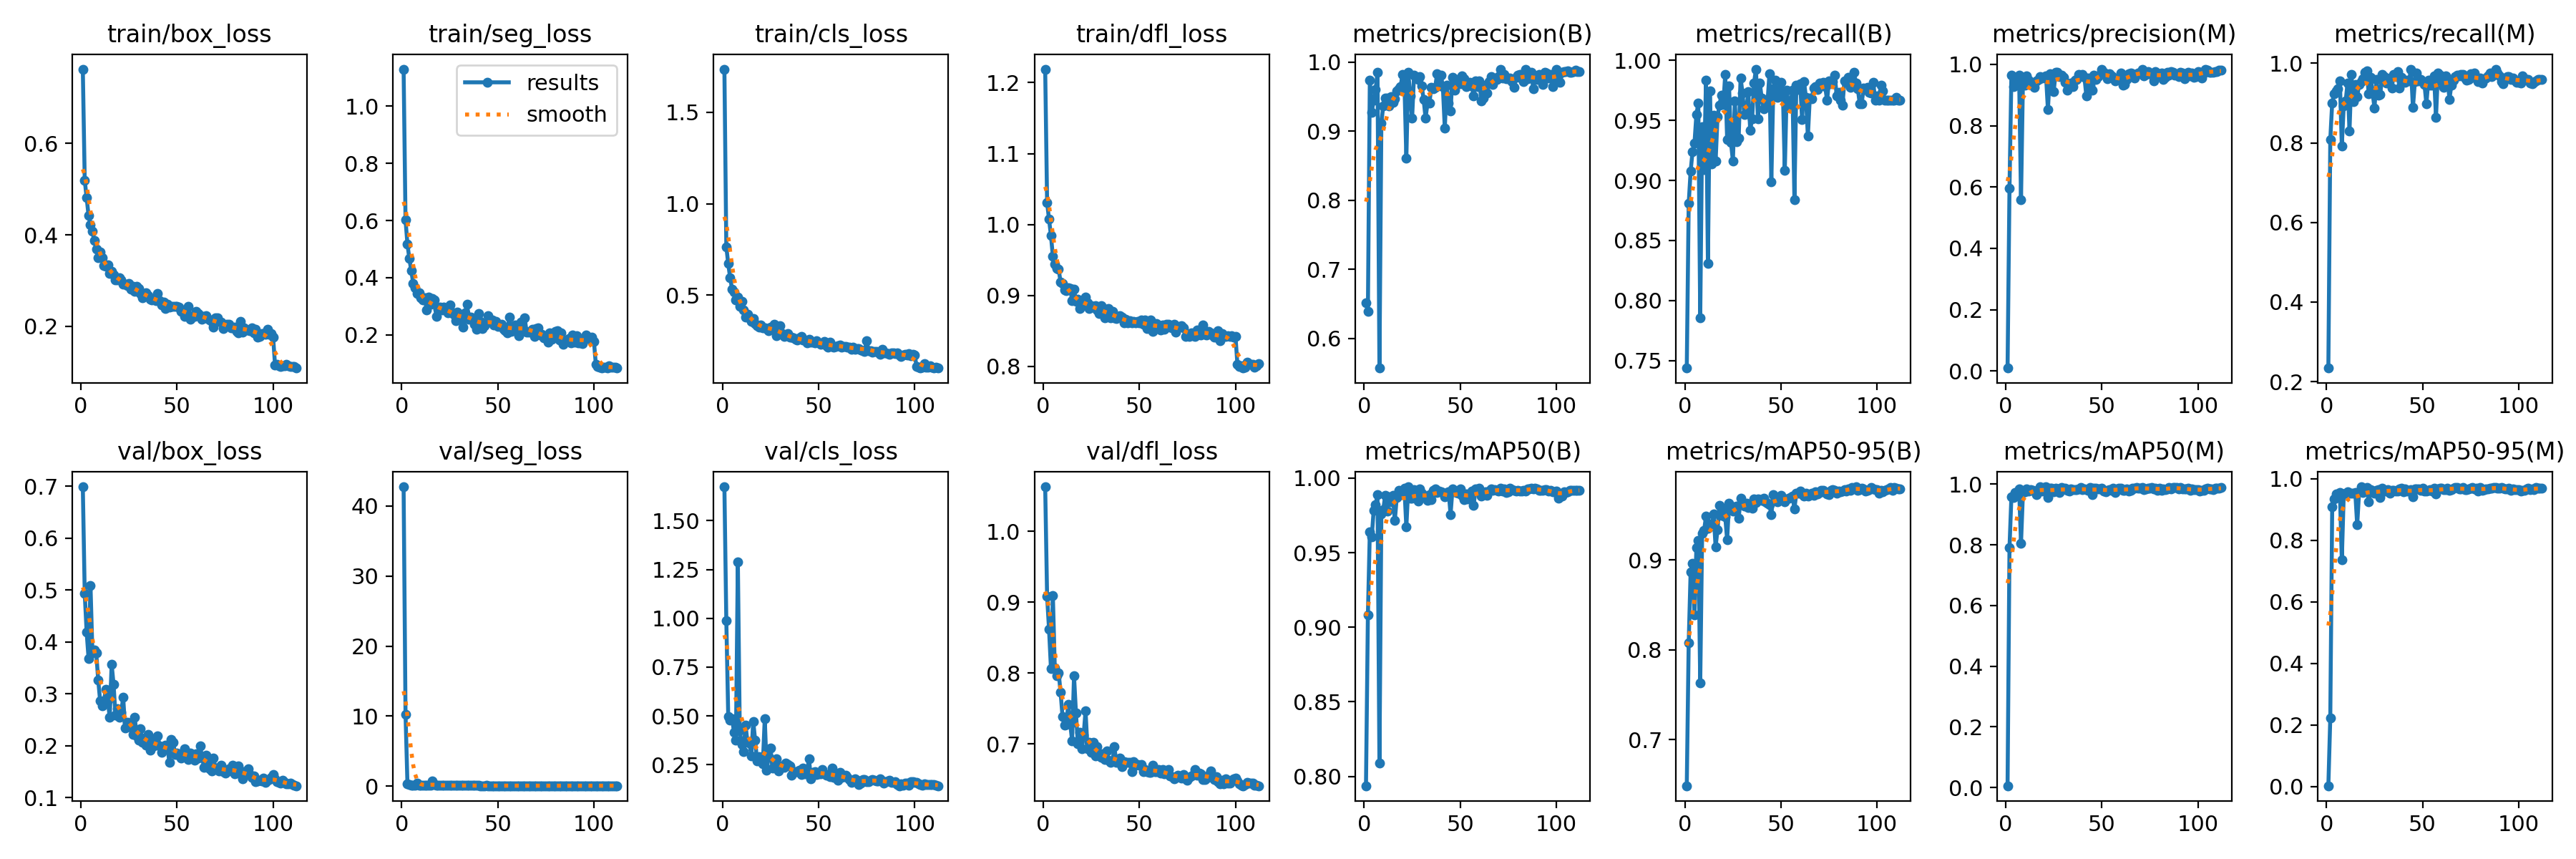


Validavimo painiavos matrica (confusion_matrix.png):


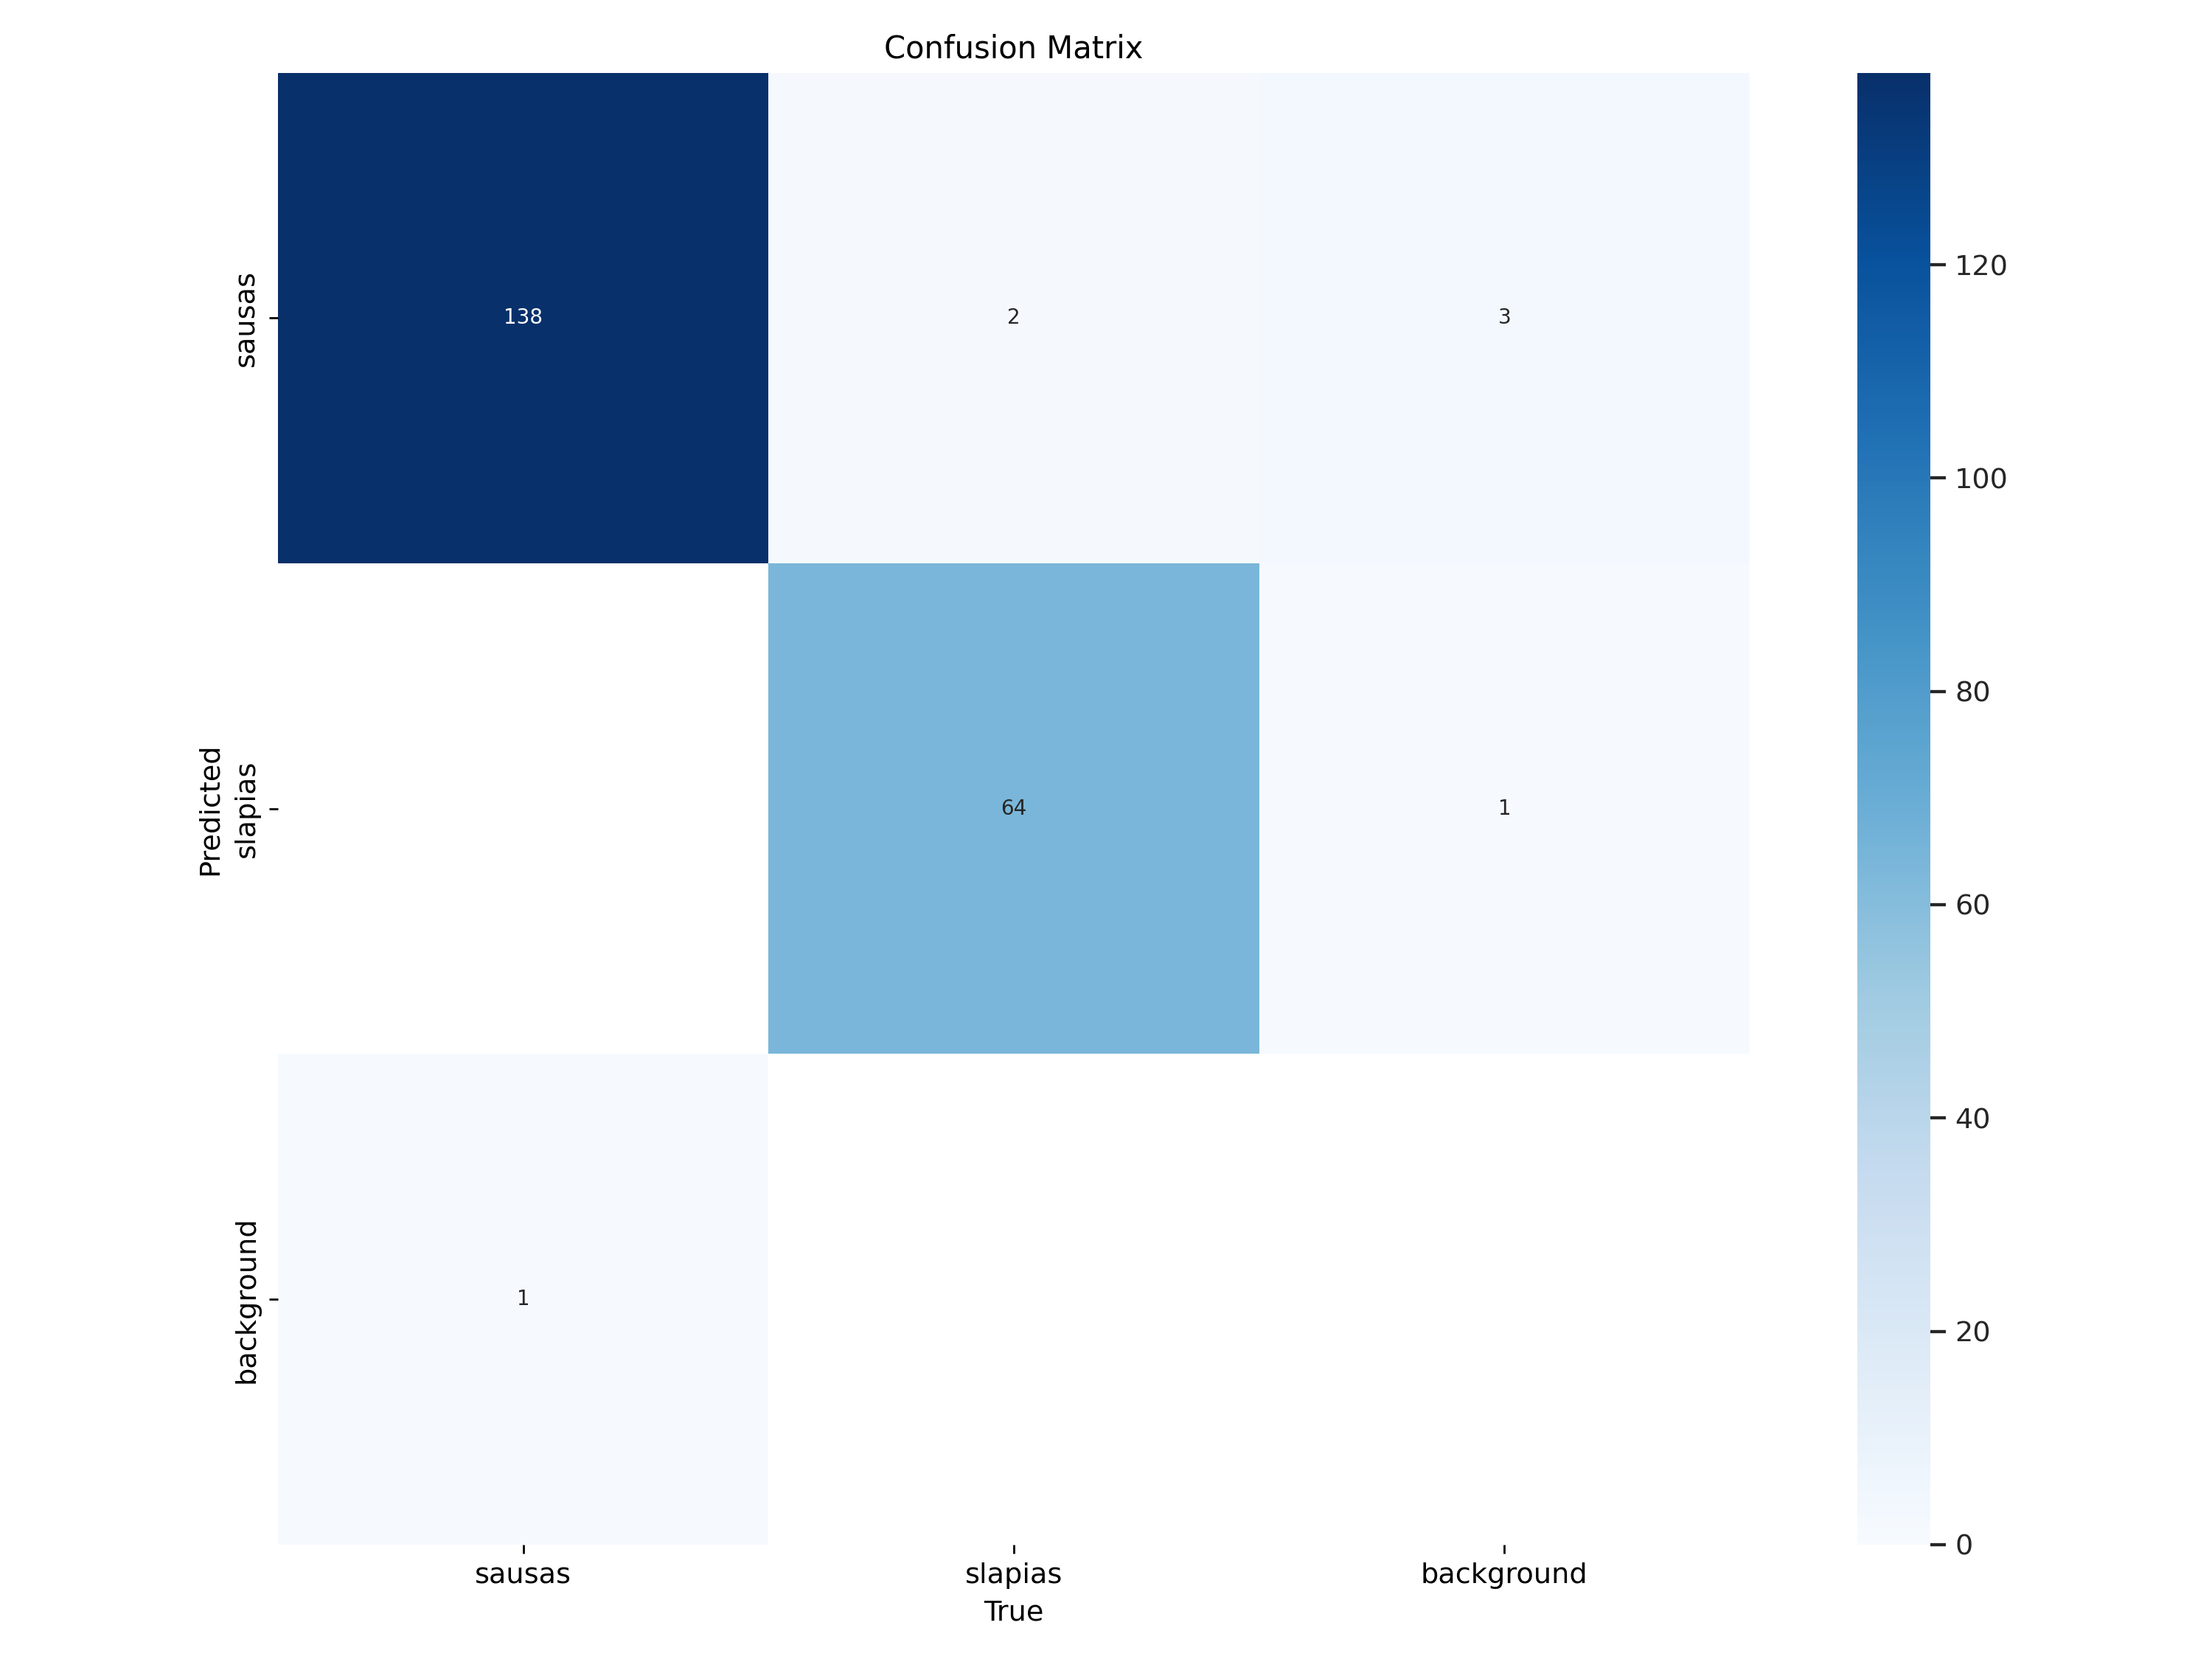

Training process finished successfully.


In [ ]:
#@title 6. Modelio mokymas su mazesniu learning rate
def train_road_wetness_model():
    """
    Mokome YOLOv8 segmentavimo modelį naudojant "Better" versijos parametrus
    ir išlaikant šio failo struktūrą.
    """
    # Nustatome bazinį žurnalo registravimą (iš "Worse" versijos)
    logging.basicConfig(level=logging.INFO,
                      format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger('train_export')

    print("\nRuošiame kelio drėgmės segmentavimo mokymą su 'Better' versijos parametrais...")
    logger.info("Pradedamas kelio drėgmės segmentavimo mokymas su 'Better' versijos parametrais")

    # Model loading logic from "Worse" version
    try:
        logger.info("Bandoma įkelti YOLOv8n-seg modelį...")
        model = YOLO('yolov8n-seg.pt') # Try hypothetical v11
        initial_model_name = 'yolov8n-seg'
        logger.info("Sėkmingai įkeltas YOLOv11n-seg modelis!")
    except Exception as e1:
        logger.warning(f"YOLOv11n-seg neprieinamas: {str(e1)}")
        try:
            logger.info("Bandoma įkelti YOLOv10n-seg modelį...")
            model = YOLO('yolov10n-seg.pt') # Try hypothetical v10
            initial_model_name = 'yolov10n-seg'
            logger.info("Sėkmingai įkeltas YOLOv10n-seg modelis!")
        except Exception as e2:
            logger.warning(f"YOLOv10n-seg neprieinamas: {str(e2)}")
            logger.info("Grįžtama prie YOLOv8n-seg modelio")
            try:
                model = YOLO('yolov8n-seg.pt') # Fallback to v8
                initial_model_name = 'yolov8n-seg'
                logger.info("Sėkmingai įkeltas YOLOv8n-seg modelis.")
            except Exception as e3:
                logger.error(f"Nepavyko įkelti jokio modelio (v11, v10, v8): {e3}")
                print(f"FATAL: Could not load any model (v11, v10, v8): {e3}")
                return None, None, None # Cannot continue without a model

    logger.info(f"Naudojamas modelis: {initial_model_name}")
    print(f"Naudojamas modelis: {initial_model_name}")

    # --- Training Parameters from "Better" version ---
    epochs = 120
    imgsz = 800 # From Better
    patience = 25
    batch_size = 12 # From Better

    lr0 = 0.0002 # From Better
    lrf = 0.005 # From Better
    weight_decay = 0.0005 # From Better
    warmup_epochs = 5.0
    dropout = 0.1
    save_period = 20 # From Better
    close_mosaic = 20 # From Better

    # Balanced augmentation configuration from "Better" version
    aug_params = {
        'hsv_h': 0.01,
        'hsv_s': 0.4,
        'hsv_v': 0.5,
        'degrees': 5.0,
        'translate': 0.1,
        'scale': 0.2,
        'fliplr': 0.5,
        'flipud': 0.0, # No vertical flip in Better version
        'mosaic': 0.4, # From Better
        'mixup': 0.1,  # From Better
    }
    # --- End of Training Parameters from "Better" version ---

    # Pradedame mokymą
    device_to_use = 0 if torch.cuda.is_available() else 'cpu'
    print(f"\nPradedame mokymą ant {device_to_use}")
    print(f"Vaizdo dydis: {imgsz}, Partijos dydis: {batch_size}, Epochos: {epochs}")
    print(f"Naudojamas svertinis duomenų įkėlėjas.") # Weighted dataloader is active
    print(f"Naudojami mokymo parametrai iš 'Better' versijos.")

    logger.info(f"Pradedamas mokymas su {initial_model_name} modeliu")
    logger.info(f"Naudojamas įrenginys: {device_to_use}")
    logger.info(f"Parametrai: imgsz={imgsz}, batch={batch_size}, epochs={epochs}, lr0={lr0}, weight_decay={weight_decay}")
    logger.info(f"Augmentacijos parametrai (YOLO): {aug_params}")

    # Ensure directories exist (good practice from Worse version)
    for dir_path in [project_dir, results_dir, predictions_dir, exports_dir]:
         if not os.path.exists(dir_path):
            os.makedirs(dir_path, exist_ok=True)
            logger.info(f"Sukurta direktorija: {dir_path}")

    try:
        # --- model.train() call using "Better" version parameters ---
        results = model.train(
            data=dataset_yaml,       # Use the YAML created in Section 4
            epochs=epochs,
            imgsz=imgsz,
            batch=batch_size,
            patience=patience,
            save=True,
            project=project_dir,     # Save results under the main project dir
            name='road_wetness_model', # Subdirectory for this run
            save_period=save_period,
            pretrained=True,         # Start from pretrained weights
            optimizer='AdamW',
            lr0=lr0,
            lrf=lrf,
            weight_decay=weight_decay,
            warmup_epochs=warmup_epochs,
            augment=True,            # Enable YOLO augmentations
            device=device_to_use,
            plots=True,              # Generate plots
            cos_lr=True,             # Cosine LR scheduler
            verbose=True,            # Show progress (NO print suppression)
            task='segment',
            dropout=dropout,
            single_cls=False,        # Multi-class problem
            close_mosaic=close_mosaic, # Close mosaic augmentation after X epochs
            **aug_params             # Apply specific augmentation parameters
        )
        # --- End of model.train() call ---

        logger.info("Apmokymas baigtas!")
        print("Mokymas baigtas!")

    except Exception as e:
        logger.error(f"Klaida mokymo metu: {str(e)}")
        print(f"Klaida mokymo metu: {str(e)}")
        traceback.print_exc()
        return None, None, None

    # Palaukti momentą (iš "Worse" versijos - gali būti naudinga)
    time.sleep(2)

    # Find best model path
    best_model_path = os.path.join(project_dir, 'road_wetness_model', 'weights', 'best.pt')

    if not os.path.exists(best_model_path):
        logger.warning(f"Best model not found at default path: {best_model_path}")
        # Try to find any .pt model (logic from Worse version)
        potential_models = glob.glob(os.path.join(project_dir, 'road_wetness_model', 'weights', '*.pt'))
        if potential_models:
            # Sort by modification time? Or just take the first found? Let's take the latest.
            potential_models.sort(key=os.path.getmtime, reverse=True)
            best_model_path = potential_models[0]
            logger.info(f"Naudojamas rastas modelis: {best_model_path}")
            print(f"Naudojame alternatyvų modelį: {best_model_path}")
        else:
            logger.error("Nepavyko rasti apmokyto modelio.")
            print("Modelio failai nerasti. Negalime tęsti.")
            return None, results, None

    logger.info(f"Geriausias modelis: {best_model_path}")
    print(f"Geriausias modelis: {best_model_path}")

    # Load best model
    try:
        best_model = YOLO(best_model_path)
    except Exception as e:
        logger.error(f"Klaida įkeliant geriausią modelį: {str(e)}")
        print(f"Klaida įkeliant geriausią modelį: {str(e)}")
        return None, results, None

    # --- Validation using "Better" version parameters ---
    logger.info("\nVykdomas validavimas...")
    print("\nVykdome validavimą...")
    val_results = None # Initialize
    try:
        val_results = best_model.val(
            data=dataset_yaml,
            split='val',
            imgsz=imgsz,
            batch=batch_size, # Use training batch size or specify different? Better used training batch size.
            plots=True,
            save_json=True, # Keep potentially useful output
            save_txt=True,  # Keep potentially useful output
            project=results_dir, # Save validation results in the dedicated results dir
            name='validation',   # Subfolder for validation run
            task='segment',
            conf=0.35,         # Balanced confidence threshold from Better
            iou=0.45           # IOU threshold from Better
        )

        # Print main metrics from Better version
        if hasattr(val_results, 'seg') and val_results.seg is not None:
             map50 = getattr(val_results.seg, 'map50', 'N/A')
             map_val = getattr(val_results.seg, 'map', 'N/A') # map50-95
             print(f"Validavimo mAP50: {map50:.4f}" if isinstance(map50, float) else f"Validavimo mAP50: {map50}")
             print(f"Validavimo mAP50-95: {map_val:.4f}" if isinstance(map_val, float) else f"Validavimo mAP50-95: {map_val}")
             logger.info(f"Validavimo mAP50: {map50}, mAP50-95: {map_val}")
        else:
             print("Validavimo segmentavimo metrikos nerastos.")
             logger.warning("Validavimo segmentavimo metrikos nerastos.")

    except Exception as e:
        logger.error(f"Klaida validavimo metu: {str(e)}")
        print(f"Klaida validavimo metu: {str(e)}")
        # Continue anyway

    # --- Prediction testing using "Better" version approach ---
    print("\nVykdome testavimo prognozes su keliais slenksčiais...")
    logger.info("Vykdomos testavimo prognozės su keliais slenksčiais ir TTA")
    try:
        test_img_dir = os.path.join(dataset_root, 'images', 'test')
        all_test_files = os.listdir(test_img_dir)
        # Select a few diverse images if possible (logic adapted from Better)
        test_images_paths = []
        shadow_samples = [f for f in all_test_files if '_shadow' in f] # Check for augmented shadows if they exist in test (unlikely with current setup)
        wet_samples = [f for f in all_test_files if not any(s in f for s in ['_shadow', '_reflect', '_reflective'])] # Assuming base names are wet/dry
        # Let's just pick a few random test images
        num_test_samples = 5
        if len(all_test_files) > num_test_samples:
             test_images_sample = random.sample(all_test_files, num_test_samples)
        else:
             test_images_sample = all_test_files

        test_images_paths = [os.path.join(test_img_dir, f) for f in test_images_sample]
        print(f"Testavimui pasirinkti vaizdai: {test_images_sample}")

        # Run predictions with multiple thresholds
        thresholds = [0.15, 0.25, 0.35, 0.45] # From Better

        for img_path in test_images_paths:
            if not os.path.exists(img_path):
                logger.warning(f"Testavimo vaizdas nerastas: {img_path}")
                continue
            img_name = os.path.basename(img_path)
            logger.info(f"Vykdoma prognozė vaizdui: {img_name}")

            for thresh in thresholds:
                pred_results = best_model.predict(
                    source=img_path,
                    save=True,
                    project=predictions_dir,
                    name=f"pred_{os.path.splitext(img_name)[0]}_thresh_{int(thresh*100)}",
                    conf=thresh,       # Current threshold
                    task='segment',
                    imgsz=imgsz,       # Specify imgsz for prediction
                    show=False,
                    save_txt=True,     # Save predicted labels
                    save_conf=True,    # Save confidences in txt files
                    boxes=True,        # Ensure boxes are saved/drawn
                    retina_masks=True, # Use high-res masks
                    line_width=2
                )
                logger.info(f"  Prognozė baigta: {img_name} (slenkstis {thresh})")

            # Also run one test with test-time augmentation (TTA) from Better
            logger.info(f"Vykdoma prognozė su TTA: {img_name}")
            pred_results_tta = best_model.predict(
                source=img_path,
                save=True,
                project=predictions_dir,
                name=f"pred_{os.path.splitext(img_name)[0]}_tta",
                conf=0.25,      # Balanced threshold for TTA (from Better)
                task='segment',
                imgsz=imgsz,    # Specify imgsz for prediction
                show=False,
                save_txt=True,
                save_conf=True,
                boxes=True,
                retina_masks=True,
                line_width=2,
                augment=True    # Enable test-time augmentation
            )
            logger.info(f"  Prognozė su TTA baigta: {img_name}")

    except Exception as e:
        logger.error(f"Klaida prognozės testavimo metu: {str(e)}")
        print(f"Klaida prognozės testavimo metu: {str(e)}")
    # --- End of Prediction testing ---


    # --- Exporting using "Better" version formats (PT, ONNX, TFLite) ---
    print("\nEksportuojame modelius (PT, ONNX, TFLite)...")
    logger.info("Eksportuojami modeliai PT, ONNX, TFLite formatais")
    export_success = {'pt': False, 'onnx': False, 'tflite': False}

    # Define export paths
    model_base_name = f"road_wetness_seg_{initial_model_name}" # Base name for exports
    pt_path = os.path.join(exports_dir, f'{model_base_name}.pt')
    onnx_path = os.path.join(exports_dir, f'{model_base_name}.onnx')


    try:
        # 1. Copy PT model
        shutil.copy(best_model_path, pt_path)
        logger.info(f"PyTorch modelis nukopijuotas į: {pt_path}")
        print(f"PyTorch modelis nukopijuotas į: {pt_path}")
        export_success['pt'] = True

        # 2. Export to ONNX (simpler export call from Better)
        logger.info("Eksportuojama į ONNX formatą...")
        print("Eksportuojama į ONNX formatą...")
        # The export function saves the file in the same directory as the model by default
        onnx_export_result_path = best_model.export(format='onnx', imgsz=imgsz, simplify=True)
        # onnx_export_result_path might be None or the actual path
        # Let's find the expected default path
        default_onnx_name = os.path.splitext(best_model_path)[0] + '.onnx'

        if os.path.exists(default_onnx_name):
             shutil.move(default_onnx_name, onnx_path) # Move it to exports dir
             logger.info(f"ONNX modelis eksportuotas ir perkeltas į: {onnx_path}")
             print(f"ONNX modelis eksportuotas ir perkeltas į: {onnx_path}")
             export_success['onnx'] = True
        elif onnx_export_result_path and os.path.exists(onnx_export_result_path):
             # If export returned a path and it exists
             shutil.move(onnx_export_result_path, onnx_path)
             logger.info(f"ONNX modelis eksportuotas (iš {onnx_export_result_path}) ir perkeltas į: {onnx_path}")
             print(f"ONNX modelis eksportuotas (iš {onnx_export_result_path}) ir perkeltas į: {onnx_path}")
             export_success['onnx'] = True
        else:
             logger.error("ONNX eksportavimas baigtas, bet failas nerastas.")
             print("ONNX eksportavimas baigtas, bet failas nerastas.")

    except Exception as e:
        logger.error(f"Klaida modelio eksportavimo metu: {str(e)}")
        print(f"Klaida modelio eksportavimo metu: {str(e)}")
        traceback.print_exc()
    # --- End of Exporting ---


    # Training results (using 'results' object)
    print("\nMokymo Rezultatai:")
    if hasattr(results, 'metrics') and results.metrics:
         final_fitness = results.metrics.get('fitness', 'N/A')
         print(f"  Galutinis tinkamumo balas (fitness): {final_fitness:.4f}" if isinstance(final_fitness, float) else f"  Galutinis tinkamumo balas (fitness): {final_fitness}")
         # You can access other metrics like mAP, precision, recall from results.metrics if needed

    # Validation results (using 'val_results' object)
    print("\nValidavimo Rezultatai:")
    if val_results and hasattr(val_results, 'seg'):
         map50 = getattr(val_results.seg, 'map50', 'N/A')
         map_val = getattr(val_results.seg, 'map', 'N/A')
         print(f"  Validavimo mAP50: {map50:.4f}" if isinstance(map50, float) else f"  Validavimo mAP50: {map50}")
         print(f"  Validavimo mAP50-95: {map_val:.4f}" if isinstance(map_val, float) else f"  Validavimo mAP50-95: {map_val}")
    else:
        print("  Validavimo metrikos negautos arba nepavyko.")

    # Export information
    print("\nEksportuoti modeliai:")
    print(f"  PyTorch (.pt): {pt_path if export_success['pt'] else 'Nepavyko'}")
    print(f"  ONNX (.onnx): {onnx_path if export_success['onnx'] else 'Nepavyko'}")
    print("\nRezultatai išsaugoti:")
    print(f"  Projekto direktorija: {project_dir}")
    print(f"  Mokymo eiga/grafikai: {os.path.join(project_dir, 'road_wetness_model')}")
    print(f"  Validavimo rezultatai: {os.path.join(results_dir, 'validation')}")
    print(f"  Prognozių pavyzdžiai: {predictions_dir}")
    print(f"  Eksportuoti modeliai: {exports_dir}")
    print("="*70)

    # Display results plots (if available)
    try:
        results_png_path = os.path.join(project_dir, 'road_wetness_model', 'results.png')
        confusion_matrix_path = os.path.join(results_dir, 'validation', 'confusion_matrix.png') # From val run

        if os.path.exists(results_png_path):
            print("\nMokymo rezultatai (results.png):")
            display(Image(results_png_path))
        if os.path.exists(confusion_matrix_path):
            print("\nValidavimo painiavos matrica (confusion_matrix.png):")
            display(Image(confusion_matrix_path))

    except Exception as e:
        logger.warning(f"Nepavyko parodyti rezultatų grafikų: {e}")
        # Pass silently if display fails

    return best_model, results, val_results
# --- End of train_road_wetness_model function ---

# Vykdyti mokymo funkciją
if __name__ == "__main__":
    # Set random seed for reproducibility where possible (add near start)
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
        # Consider adding these for more determinism, but they can impact performance
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

    print("Starting training process...")
    model, train_res, val_res = train_road_wetness_model()
    if model:
        print("Training process finished successfully.")
    else:
        print("Training process encountered an error.")


In [ ]:
#@title 6. Modelio mokymas su "Better" versijos parametrais
def train_road_wetness_model():
    """
    Mokome YOLOv8 segmentavimo modelį naudojant "Better" versijos parametrus
    ir išlaikant šio failo struktūrą.
    """
    # Nustatome bazinį žurnalo registravimą (iš "Worse" versijos)
    logging.basicConfig(level=logging.INFO,
                      format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger('train_export')

    print("\nRuošiame kelio drėgmės segmentavimo mokymą su 'Better' versijos parametrais...")
    logger.info("Pradedamas kelio drėgmės segmentavimo mokymas su 'Better' versijos parametrais")

    # Model loading logic from "Worse" version
    try:
        logger.info("Bandoma įkelti YOLOv8n-seg modelį...")
        model = YOLO('yolov8n-seg.pt') # Try hypothetical v11
        initial_model_name = 'yolov8n-seg'
        logger.info("Sėkmingai įkeltas YOLOv11n-seg modelis!")
    except Exception as e1:
        logger.warning(f"YOLOv11n-seg neprieinamas: {str(e1)}")
        try:
            logger.info("Bandoma įkelti YOLOv10n-seg modelį...")
            model = YOLO('yolov10n-seg.pt') # Try hypothetical v10
            initial_model_name = 'yolov10n-seg'
            logger.info("Sėkmingai įkeltas YOLOv10n-seg modelis!")
        except Exception as e2:
            logger.warning(f"YOLOv10n-seg neprieinamas: {str(e2)}")
            logger.info("Grįžtama prie YOLOv8n-seg modelio")
            try:
                model = YOLO('yolov8n-seg.pt') # Fallback to v8
                initial_model_name = 'yolov8n-seg'
                logger.info("Sėkmingai įkeltas YOLOv8n-seg modelis.")
            except Exception as e3:
                logger.error(f"Nepavyko įkelti jokio modelio (v11, v10, v8): {e3}")
                print(f"FATAL: Could not load any model (v11, v10, v8): {e3}")
                return None, None, None # Cannot continue without a model

    logger.info(f"Naudojamas modelis: {initial_model_name}")
    print(f"Naudojamas modelis: {initial_model_name}")

    # --- Training Parameters from "Better" version ---
    epochs = 120
    imgsz = 800 # From Better
    patience = 25
    batch_size = 8 # From Better
    optimizer = 'AdamW'
    lr0 = 0.001 # From Better
    lrf = 0.01 # From Better
    weight_decay = 0.0005 # From Better
    warmup_epochs = 5.0
    dropout = 0.1
    label_smoothing = 0.05
    save_period = 20 # From Better
    close_mosaic = 20 # From Better
    amp_enabled = True # From Better

    # Balanced augmentation configuration from "Better" version
    aug_params = {
        'hsv_h': 0.01,
        'hsv_s': 0.4,
        'hsv_v': 0.5,
        'degrees': 5.0,
        'translate': 0.1,
        'scale': 0.2,
        'fliplr': 0.5,
        'flipud': 0.0, # No vertical flip in Better version
        'mosaic': 0.4, # From Better
        'mixup': 0.1,  # From Better
    }
    # --- End of Training Parameters from "Better" version ---

    # Pradedame mokymą
    device_to_use = 0 if torch.cuda.is_available() else 'cpu'
    print(f"\nPradedame mokymą ant {device_to_use}")
    print(f"Vaizdo dydis: {imgsz}, Partijos dydis: {batch_size}, Epochos: {epochs}")
    print(f"Naudojamas svertinis duomenų įkėlėjas.") # Weighted dataloader is active
    print(f"Naudojami mokymo parametrai iš 'Better' versijos.")

    logger.info(f"Pradedamas mokymas su {initial_model_name} modeliu")
    logger.info(f"Naudojamas įrenginys: {device_to_use}")
    logger.info(f"Parametrai: imgsz={imgsz}, batch={batch_size}, epochs={epochs}, lr0={lr0}, weight_decay={weight_decay}")
    logger.info(f"Augmentacijos parametrai (YOLO): {aug_params}")

    # Ensure directories exist (good practice from Worse version)
    for dir_path in [project_dir, results_dir, predictions_dir, exports_dir]:
         if not os.path.exists(dir_path):
            os.makedirs(dir_path, exist_ok=True)
            logger.info(f"Sukurta direktorija: {dir_path}")

    try:
        # --- model.train() call using "Better" version parameters ---
        results = model.train(
            data=dataset_yaml,       # Use the YAML created in Section 4
            epochs=epochs,
            imgsz=imgsz,
            batch=batch_size,
            patience=patience,
            save=True,
            project=project_dir,     # Save results under the main project dir
            name='road_wetness_model', # Subdirectory for this run
            save_period=save_period,
            pretrained=True,         # Start from pretrained weights
            optimizer=optimizer,
            lr0=lr0,
            lrf=lrf,
            weight_decay=weight_decay,
            warmup_epochs=warmup_epochs,
            augment=True,            # Enable YOLO augmentations
            device=device_to_use,
            plots=True,              # Generate plots
            cos_lr=True,             # Cosine LR scheduler
            verbose=True,            # Show progress (NO print suppression)
            task='segment',
            dropout=dropout,
            label_smoothing=label_smoothing,
            overlap_mask=True,       # From Better
            mask_ratio=4,            # From Better
            single_cls=False,        # Multi-class problem
            close_mosaic=close_mosaic, # Close mosaic augmentation after X epochs
            amp=amp_enabled,         # Mixed precision training
            **aug_params             # Apply specific augmentation parameters
        )
        # --- End of model.train() call ---

        logger.info("Apmokymas baigtas!")
        print("Mokymas baigtas!")

    except Exception as e:
        logger.error(f"Klaida mokymo metu: {str(e)}")
        print(f"Klaida mokymo metu: {str(e)}")
        traceback.print_exc()
        return None, None, None

    # Palaukti momentą (iš "Worse" versijos - gali būti naudinga)
    time.sleep(2)

    # Find best model path
    best_model_path = os.path.join(project_dir, 'road_wetness_model', 'weights', 'best.pt')

    if not os.path.exists(best_model_path):
        logger.warning(f"Best model not found at default path: {best_model_path}")
        # Try to find any .pt model (logic from Worse version)
        potential_models = glob.glob(os.path.join(project_dir, 'road_wetness_model', 'weights', '*.pt'))
        if potential_models:
            # Sort by modification time? Or just take the first found? Let's take the latest.
            potential_models.sort(key=os.path.getmtime, reverse=True)
            best_model_path = potential_models[0]
            logger.info(f"Naudojamas rastas modelis: {best_model_path}")
            print(f"Naudojame alternatyvų modelį: {best_model_path}")
        else:
            logger.error("Nepavyko rasti apmokyto modelio.")
            print("Modelio failai nerasti. Negalime tęsti.")
            return None, results, None

    logger.info(f"Geriausias modelis: {best_model_path}")
    print(f"Geriausias modelis: {best_model_path}")

    # Load best model
    try:
        best_model = YOLO(best_model_path)
    except Exception as e:
        logger.error(f"Klaida įkeliant geriausią modelį: {str(e)}")
        print(f"Klaida įkeliant geriausią modelį: {str(e)}")
        return None, results, None

    # --- Validation using "Better" version parameters ---
    logger.info("\nVykdomas validavimas...")
    print("\nVykdome validavimą...")
    val_results = None # Initialize
    try:
        val_results = best_model.val(
            data=dataset_yaml,
            split='val',
            imgsz=imgsz,
            batch=batch_size, # Use training batch size or specify different? Better used training batch size.
            plots=True,
            save_json=True, # Keep potentially useful output
            save_txt=True,  # Keep potentially useful output
            project=results_dir, # Save validation results in the dedicated results dir
            name='validation',   # Subfolder for validation run
            task='segment',
            conf=0.35,         # Balanced confidence threshold from Better
            iou=0.45           # IOU threshold from Better
        )

        # Print main metrics from Better version
        if hasattr(val_results, 'seg') and val_results.seg is not None:
             map50 = getattr(val_results.seg, 'map50', 'N/A')
             map_val = getattr(val_results.seg, 'map', 'N/A') # map50-95
             print(f"Validavimo mAP50: {map50:.4f}" if isinstance(map50, float) else f"Validavimo mAP50: {map50}")
             print(f"Validavimo mAP50-95: {map_val:.4f}" if isinstance(map_val, float) else f"Validavimo mAP50-95: {map_val}")
             logger.info(f"Validavimo mAP50: {map50}, mAP50-95: {map_val}")
        else:
             print("Validavimo segmentavimo metrikos nerastos.")
             logger.warning("Validavimo segmentavimo metrikos nerastos.")

    except Exception as e:
        logger.error(f"Klaida validavimo metu: {str(e)}")
        print(f"Klaida validavimo metu: {str(e)}")
        # Continue anyway

    # --- Prediction testing using "Better" version approach ---
    print("\nVykdome testavimo prognozes su keliais slenksčiais...")
    logger.info("Vykdomos testavimo prognozės su keliais slenksčiais ir TTA")
    try:
        test_img_dir = os.path.join(dataset_root, 'images', 'test')
        all_test_files = os.listdir(test_img_dir)
        # Select a few diverse images if possible (logic adapted from Better)
        test_images_paths = []
        shadow_samples = [f for f in all_test_files if '_shadow' in f] # Check for augmented shadows if they exist in test (unlikely with current setup)
        wet_samples = [f for f in all_test_files if not any(s in f for s in ['_shadow', '_reflect', '_reflective'])] # Assuming base names are wet/dry
        # Let's just pick a few random test images
        num_test_samples = 5
        if len(all_test_files) > num_test_samples:
             test_images_sample = random.sample(all_test_files, num_test_samples)
        else:
             test_images_sample = all_test_files

        test_images_paths = [os.path.join(test_img_dir, f) for f in test_images_sample]
        print(f"Testavimui pasirinkti vaizdai: {test_images_sample}")

        # Run predictions with multiple thresholds
        thresholds = [0.15, 0.25, 0.35, 0.45] # From Better

        for img_path in test_images_paths:
            if not os.path.exists(img_path):
                logger.warning(f"Testavimo vaizdas nerastas: {img_path}")
                continue
            img_name = os.path.basename(img_path)
            logger.info(f"Vykdoma prognozė vaizdui: {img_name}")

            for thresh in thresholds:
                pred_results = best_model.predict(
                    source=img_path,
                    save=True,
                    project=predictions_dir,
                    name=f"pred_{os.path.splitext(img_name)[0]}_thresh_{int(thresh*100)}",
                    conf=thresh,       # Current threshold
                    task='segment',
                    imgsz=imgsz,       # Specify imgsz for prediction
                    show=False,
                    save_txt=True,     # Save predicted labels
                    save_conf=True,    # Save confidences in txt files
                    boxes=True,        # Ensure boxes are saved/drawn
                    retina_masks=True, # Use high-res masks
                    line_width=2
                )
                logger.info(f"  Prognozė baigta: {img_name} (slenkstis {thresh})")

            # Also run one test with test-time augmentation (TTA) from Better
            logger.info(f"Vykdoma prognozė su TTA: {img_name}")
            pred_results_tta = best_model.predict(
                source=img_path,
                save=True,
                project=predictions_dir,
                name=f"pred_{os.path.splitext(img_name)[0]}_tta",
                conf=0.25,      # Balanced threshold for TTA (from Better)
                task='segment',
                imgsz=imgsz,    # Specify imgsz for prediction
                show=False,
                save_txt=True,
                save_conf=True,
                boxes=True,
                retina_masks=True,
                line_width=2,
                augment=True    # Enable test-time augmentation
            )
            logger.info(f"  Prognozė su TTA baigta: {img_name}")

    except Exception as e:
        logger.error(f"Klaida prognozės testavimo metu: {str(e)}")
        print(f"Klaida prognozės testavimo metu: {str(e)}")
    # --- End of Prediction testing ---


    # --- Exporting using "Better" version formats (PT, ONNX, TFLite) ---
    print("\nEksportuojame modelius (PT, ONNX, TFLite)...")
    logger.info("Eksportuojami modeliai PT, ONNX, TFLite formatais")
    export_success = {'pt': False, 'onnx': False, 'tflite': False}

    # Define export paths
    model_base_name = f"road_wetness_seg_{initial_model_name}" # Base name for exports
    pt_path = os.path.join(exports_dir, f'{model_base_name}.pt')
    onnx_path = os.path.join(exports_dir, f'{model_base_name}.onnx')


    try:
        # 1. Copy PT model
        shutil.copy(best_model_path, pt_path)
        logger.info(f"PyTorch modelis nukopijuotas į: {pt_path}")
        print(f"PyTorch modelis nukopijuotas į: {pt_path}")
        export_success['pt'] = True

        # 2. Export to ONNX (simpler export call from Better)
        logger.info("Eksportuojama į ONNX formatą...")
        print("Eksportuojama į ONNX formatą...")
        # The export function saves the file in the same directory as the model by default
        onnx_export_result_path = best_model.export(format='onnx', imgsz=imgsz, simplify=True)
        # onnx_export_result_path might be None or the actual path
        # Let's find the expected default path
        default_onnx_name = os.path.splitext(best_model_path)[0] + '.onnx'

        if os.path.exists(default_onnx_name):
             shutil.move(default_onnx_name, onnx_path) # Move it to exports dir
             logger.info(f"ONNX modelis eksportuotas ir perkeltas į: {onnx_path}")
             print(f"ONNX modelis eksportuotas ir perkeltas į: {onnx_path}")
             export_success['onnx'] = True
        elif onnx_export_result_path and os.path.exists(onnx_export_result_path):
             # If export returned a path and it exists
             shutil.move(onnx_export_result_path, onnx_path)
             logger.info(f"ONNX modelis eksportuotas (iš {onnx_export_result_path}) ir perkeltas į: {onnx_path}")
             print(f"ONNX modelis eksportuotas (iš {onnx_export_result_path}) ir perkeltas į: {onnx_path}")
             export_success['onnx'] = True
        else:
             logger.error("ONNX eksportavimas baigtas, bet failas nerastas.")
             print("ONNX eksportavimas baigtas, bet failas nerastas.")

    except Exception as e:
        logger.error(f"Klaida modelio eksportavimo metu: {str(e)}")
        print(f"Klaida modelio eksportavimo metu: {str(e)}")
        traceback.print_exc()
    # --- End of Exporting ---


    # Training results (using 'results' object)
    print("\nMokymo Rezultatai:")
    if hasattr(results, 'metrics') and results.metrics:
         final_fitness = results.metrics.get('fitness', 'N/A')
         print(f"  Galutinis tinkamumo balas (fitness): {final_fitness:.4f}" if isinstance(final_fitness, float) else f"  Galutinis tinkamumo balas (fitness): {final_fitness}")
         # You can access other metrics like mAP, precision, recall from results.metrics if needed

    # Validation results (using 'val_results' object)
    print("\nValidavimo Rezultatai:")
    if val_results and hasattr(val_results, 'seg'):
         map50 = getattr(val_results.seg, 'map50', 'N/A')
         map_val = getattr(val_results.seg, 'map', 'N/A')
         print(f"  Validavimo mAP50: {map50:.4f}" if isinstance(map50, float) else f"  Validavimo mAP50: {map50}")
         print(f"  Validavimo mAP50-95: {map_val:.4f}" if isinstance(map_val, float) else f"  Validavimo mAP50-95: {map_val}")
    else:
        print("  Validavimo metrikos negautos arba nepavyko.")

    # Export information
    print("\nEksportuoti modeliai:")
    print(f"  PyTorch (.pt): {pt_path if export_success['pt'] else 'Nepavyko'}")
    print(f"  ONNX (.onnx): {onnx_path if export_success['onnx'] else 'Nepavyko'}")
    print(f"  TFLite (.tflite): {tflite_path if export_success['tflite'] else 'Nepavyko'}")

    print("\nRezultatai išsaugoti:")
    print(f"  Projekto direktorija: {project_dir}")
    print(f"  Mokymo eiga/grafikai: {os.path.join(project_dir, 'road_wetness_model')}")
    print(f"  Validavimo rezultatai: {os.path.join(results_dir, 'validation')}")
    print(f"  Prognozių pavyzdžiai: {predictions_dir}")
    print(f"  Eksportuoti modeliai: {exports_dir}")
    print("="*70)

    # Display results plots (if available)
    try:
        results_png_path = os.path.join(project_dir, 'road_wetness_model', 'results.png')
        confusion_matrix_path = os.path.join(results_dir, 'validation', 'confusion_matrix.png') # From val run

        if os.path.exists(results_png_path):
            print("\nMokymo rezultatai (results.png):")
            display(Image(results_png_path))
        if os.path.exists(confusion_matrix_path):
            print("\nValidavimo painiavos matrica (confusion_matrix.png):")
            display(Image(confusion_matrix_path))

    except Exception as e:
        logger.warning(f"Nepavyko parodyti rezultatų grafikų: {e}")
        # Pass silently if display fails

    return best_model, results, val_results
# --- End of train_road_wetness_model function ---

# Vykdyti mokymo funkciją
if __name__ == "__main__":
    # Set random seed for reproducibility where possible (add near start)
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
        # Consider adding these for more determinism, but they can impact performance
        # torch.backends.cudnn.deterministic = True
        # torch.backends.cudnn.benchmark = False

    print("Starting training process...")
    model, train_res, val_res = train_road_wetness_model()
    if model:
        print("Training process finished successfully.")
    else:
        print("Training process encountered an error.")


Starting training process...

Ruošiame kelio drėgmės segmentavimo mokymą su 'Better' versijos parametrais...
Naudojamas modelis: yolov8n-seg

Pradedame mokymą ant 0
Vaizdo dydis: 800, Partijos dydis: 8, Epochos: 120
Naudojamas svertinis duomenų įkėlėjas.
Naudojami mokymo parametrai iš 'Better' versijos.
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=20, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250505_222221/dataset.yaml, degrees=5.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, for

train: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250505_222221/labels/train.cache... 1532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1532/1532 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 6.1±5.2 ms, read: 43.0±18.3 MB/s, size: 748.8 KB)


val: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250505_222221/labels/val.cache... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/road_wetness_model3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/road_wetness_model3
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/120      2.26G     0.7286     0.9211      1.415      1.177         11        800: 100%|██████████| 192/192 [02:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]

                   all        166        205      0.753      0.743      0.878      0.666     0.0363     0.0547    0.00638    0.00224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/120      2.49G     0.5816     0.6092     0.7188      1.046         14        800: 100%|██████████| 192/192 [02:23<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]

                   all        166        205       0.85      0.806      0.895      0.781      0.836      0.795      0.865      0.705



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/120      2.51G     0.5877     0.5962     0.6716      1.037         16        800: 100%|██████████| 192/192 [02:16<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]

                   all        166        205      0.942      0.898      0.951      0.802      0.947      0.902      0.959      0.906



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/120      2.51G     0.5635     0.5671     0.6505      1.034          8        800: 100%|██████████| 192/192 [02:30<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]

                   all        166        205       0.96      0.894      0.976      0.865      0.956       0.89      0.972      0.928



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/120      2.53G     0.5191     0.4992     0.5868     0.9987          8        800: 100%|██████████| 192/192 [02:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.45it/s]

                   all        166        205      0.982      0.897      0.968      0.857      0.981      0.898      0.984      0.953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/120      2.55G     0.5116     0.4373      0.577     0.9854          4        800: 100%|██████████| 192/192 [02:34<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]

                   all        166        205      0.944      0.908      0.972      0.867      0.944      0.902      0.972      0.933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/120      2.56G     0.4975     0.4264     0.5238     0.9661          4        800: 100%|██████████| 192/192 [02:51<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


                   all        166        205      0.956      0.896      0.967      0.898      0.956      0.896      0.967      0.938

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/120      2.57G     0.4714     0.4639      0.545     0.9732          6        800: 100%|██████████| 192/192 [02:40<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]

                   all        166        205      0.966      0.941      0.985        0.9      0.973      0.918      0.979       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/120      2.58G     0.4476     0.3963     0.4949     0.9581          6        800: 100%|██████████| 192/192 [02:45<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]

                   all        166        205      0.976      0.879      0.972      0.898      0.967      0.872      0.965       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/120      2.58G     0.4193     0.3817     0.4576     0.9423          7        800: 100%|██████████| 192/192 [03:29<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.69it/s]

                   all        166        205      0.933      0.929      0.978      0.912      0.933      0.929      0.978      0.945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/120      2.58G     0.4451     0.4216     0.4567     0.9511          8        800: 100%|██████████| 192/192 [02:44<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.50it/s]

                   all        166        205      0.953      0.945      0.984      0.906      0.971      0.926       0.98      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/120      2.58G     0.4108     0.4094     0.4235     0.9372          7        800: 100%|██████████| 192/192 [02:31<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.25it/s]

                   all        166        205      0.933      0.956      0.987       0.93      0.929      0.952      0.983       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/120      2.58G      0.408       0.41     0.4124     0.9288          7        800: 100%|██████████| 192/192 [02:37<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.27s/it]

                   all        166        205      0.948      0.954       0.98      0.909      0.944      0.951      0.979      0.952



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/120      2.58G     0.4285      0.387     0.4328     0.9407          5        800: 100%|██████████| 192/192 [02:32<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.50it/s]

                   all        166        205      0.931      0.947      0.982      0.915      0.923       0.94      0.979      0.956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/120      2.58G     0.3988     0.3759     0.4108     0.9228         11        800: 100%|██████████| 192/192 [04:16<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]

                   all        166        205      0.977      0.916      0.982       0.93      0.977      0.916      0.981      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/120      2.58G     0.3822     0.3514     0.3922     0.9237          5        800: 100%|██████████| 192/192 [03:15<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.61it/s]

                   all        166        205      0.929      0.859      0.978      0.906       0.86      0.909      0.974      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/120      2.58G     0.3853     0.3576      0.384     0.9238         17        800: 100%|██████████| 192/192 [02:22<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]

                   all        166        205      0.972      0.942      0.988      0.925      0.964      0.935      0.981      0.949



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/120      2.58G     0.3704     0.3677     0.3816     0.9143          5        800: 100%|██████████| 192/192 [02:24<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.29it/s]

                   all        166        205       0.92      0.881      0.973      0.929       0.92      0.881      0.969      0.943



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/120      2.58G     0.3744     0.3504     0.3879     0.9134         19        800: 100%|██████████| 192/192 [05:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]

                   all        166        205      0.981      0.955      0.989      0.938      0.977      0.952      0.981       0.95



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/120      2.58G     0.3776     0.3476     0.3852     0.9144          5        800: 100%|██████████| 192/192 [06:58<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]


                   all        166        205      0.953      0.964      0.982      0.926      0.956      0.967      0.984      0.947

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/120      2.58G     0.3492     0.3284      0.351     0.8977         13        800: 100%|██████████| 192/192 [05:47<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]

                   all        166        205      0.976      0.975      0.993       0.94      0.976      0.971       0.99      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/120      2.58G     0.3484     0.2943      0.366     0.8975         13        800: 100%|██████████| 192/192 [03:27<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:20<00:00,  1.88s/it]

                   all        166        205      0.938      0.941      0.984      0.931      0.923      0.927      0.971      0.945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/120      2.58G      0.345     0.3206     0.3604     0.8985          9        800: 100%|██████████| 192/192 [02:17<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.63it/s]

                   all        166        205      0.957      0.963      0.986      0.946       0.95      0.953      0.975      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/120      2.58G     0.3365     0.3166     0.3452      0.892          4        800: 100%|██████████| 192/192 [02:09<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.35it/s]

                   all        166        205      0.913      0.905      0.977      0.938      0.912      0.902      0.972      0.945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/120      2.58G     0.3367      0.348     0.3521     0.8934          7        800: 100%|██████████| 192/192 [02:15<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.13it/s]


                   all        166        205      0.934      0.953      0.987      0.937      0.948      0.933      0.976      0.954

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/120      2.58G     0.3436     0.3364     0.3562     0.9007          6        800: 100%|██████████| 192/192 [02:29<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]

                   all        166        205       0.96      0.818      0.963      0.919      0.976      0.814      0.955      0.921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/120      2.58G      0.331     0.3149     0.3448     0.8968          5        800: 100%|██████████| 192/192 [02:29<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]

                   all        166        205       0.96      0.967      0.987      0.944      0.946      0.953      0.981       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/120      2.58G     0.3297     0.2927      0.333     0.8938          9        800: 100%|██████████| 192/192 [02:23<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]


                   all        166        205      0.952      0.908       0.99      0.949      0.935      0.892       0.98      0.956

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/120      2.58G     0.3291      0.318     0.3204     0.8872         10        800: 100%|██████████| 192/192 [02:13<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.47it/s]

                   all        166        205      0.994      0.956      0.988      0.943      0.985      0.948      0.979      0.957



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/120      2.58G     0.3411     0.3543     0.3641     0.8967          9        800: 100%|██████████| 192/192 [02:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.24it/s]

                   all        166        205      0.953      0.927      0.986      0.944      0.953      0.927      0.987      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/120      2.58G     0.3158     0.3217     0.3232      0.888          6        800: 100%|██████████| 192/192 [02:09<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.65it/s]

                   all        166        205       0.98      0.972       0.99      0.952      0.979       0.96      0.988      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/120      2.58G     0.3274     0.2983     0.3254     0.8993          6        800: 100%|██████████| 192/192 [02:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.76it/s]

                   all        166        205      0.958       0.96      0.989      0.945      0.951      0.952      0.987      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/120      2.58G       0.33     0.3389     0.3402     0.8922          6        800: 100%|██████████| 192/192 [02:21<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


                   all        166        205      0.962      0.977      0.991      0.944      0.952      0.964      0.985       0.96

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/120      2.58G     0.3046      0.324     0.3034     0.8892          7        800: 100%|██████████| 192/192 [02:25<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.12it/s]

                   all        166        205      0.981      0.956      0.991      0.953      0.973      0.948      0.988      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/120      2.58G     0.3123     0.3122     0.3151      0.889          7        800: 100%|██████████| 192/192 [02:06<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.36it/s]

                   all        166        205      0.967      0.954      0.987       0.93       0.96      0.939      0.976      0.947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/120      2.58G     0.3015     0.2828     0.3083     0.8819          6        800: 100%|██████████| 192/192 [02:14<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.45it/s]

                   all        166        205      0.948      0.965      0.988      0.949      0.941      0.958      0.985      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/120      2.58G     0.3053     0.3122      0.306     0.8874          8        800: 100%|██████████| 192/192 [02:13<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]

                   all        166        205      0.904      0.862      0.963      0.932      0.908      0.858      0.957       0.94



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/120      2.58G     0.2945     0.2925      0.304     0.8793         17        800: 100%|██████████| 192/192 [02:12<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]

                   all        166        205      0.974      0.944      0.985      0.948      0.963      0.934      0.971      0.951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/120      2.58G     0.3032     0.2605     0.2996     0.8831          4        800: 100%|██████████| 192/192 [02:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.39it/s]

                   all        166        205      0.947       0.96      0.988      0.953      0.964      0.933       0.98      0.962



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/120      2.58G      0.289     0.2823     0.3037     0.8754          5        800: 100%|██████████| 192/192 [02:07<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]

                   all        166        205      0.981       0.96       0.99       0.95      0.981       0.96       0.99      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/120      2.58G     0.3141     0.3117     0.3022     0.8848         13        800: 100%|██████████| 192/192 [02:13<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]

                   all        166        205      0.977      0.956      0.989      0.949      0.976      0.948      0.984      0.955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/120      2.58G     0.2883     0.2398     0.2958     0.8669          4        800: 100%|██████████| 192/192 [02:15<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]

                   all        166        205      0.954      0.981       0.99      0.957      0.969      0.933      0.982      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/120      2.58G     0.2947     0.2737     0.2825     0.8727         12        800: 100%|██████████| 192/192 [03:30<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.17it/s]

                   all        166        205      0.954      0.971      0.989      0.944      0.942      0.949      0.985      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/120      2.58G     0.2965     0.2835     0.2845     0.8766         13        800: 100%|██████████| 192/192 [04:59<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.09it/s]

                   all        166        205      0.977      0.965      0.985      0.956       0.97      0.945      0.978      0.956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/120      2.58G     0.2891     0.2808     0.2909     0.8816          7        800: 100%|██████████| 192/192 [05:57<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:18<00:00,  1.70s/it]

                   all        166        205      0.983      0.945      0.983      0.943      0.978      0.934      0.976      0.954



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/120      2.58G     0.2783     0.2812     0.2887     0.8782          8        800: 100%|██████████| 192/192 [05:44<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]


                   all        166        205      0.989       0.97      0.991      0.955      0.977      0.948      0.979      0.958

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/120      2.58G     0.2815     0.2596     0.2757     0.8716          4        800: 100%|██████████| 192/192 [09:14<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.09s/it]

                   all        166        205      0.972      0.989      0.993      0.962      0.962      0.978       0.99      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/120      2.58G     0.2766     0.2624     0.2727     0.8729         14        800: 100%|██████████| 192/192 [06:55<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.42it/s]

                   all        166        205      0.979      0.952       0.99      0.961      0.965      0.938      0.983      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/120      2.58G     0.2801     0.2823     0.2747     0.8778          9        800: 100%|██████████| 192/192 [02:04<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]

                   all        166        205      0.985      0.962      0.988       0.96       0.97      0.948      0.981      0.959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/120      2.58G     0.2726     0.2624     0.2659     0.8679          8        800: 100%|██████████| 192/192 [02:21<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.40it/s]

                   all        166        205      0.976      0.954       0.99      0.966       0.99      0.919      0.986      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/120      2.58G     0.2558      0.249     0.2593     0.8637         11        800: 100%|██████████| 192/192 [02:22<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]

                   all        166        205      0.983      0.961      0.993      0.963      0.968      0.946      0.984      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/120      2.58G     0.2675     0.2798     0.2656     0.8723          8        800: 100%|██████████| 192/192 [02:25<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.73it/s]

                   all        166        205      0.961      0.982      0.992      0.956      0.957      0.967      0.987      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/120      2.58G     0.2616      0.274     0.2532     0.8627          7        800: 100%|██████████| 192/192 [02:16<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]

                   all        166        205      0.992      0.961      0.993      0.967      0.977      0.947      0.988      0.959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/120      2.58G     0.2583     0.2367     0.2591     0.8652         11        800: 100%|██████████| 192/192 [02:21<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]

                   all        166        205      0.948      0.938      0.989      0.964      0.966      0.911      0.986      0.968



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/120      2.58G     0.2587     0.2523     0.2533     0.8636          5        800: 100%|██████████| 192/192 [02:18<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.77it/s]

                   all        166        205      0.996      0.974      0.994      0.966      0.981      0.958      0.989      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/120      2.58G     0.2547     0.2413     0.2409     0.8585          9        800: 100%|██████████| 192/192 [02:12<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.82it/s]

                   all        166        205      0.968      0.976      0.987       0.96      0.954      0.961      0.982       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/120      2.58G      0.268     0.2756     0.2556     0.8734          5        800: 100%|██████████| 192/192 [02:18<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]

                   all        166        205      0.976      0.975      0.991      0.963      0.959      0.956      0.982       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/120      2.58G      0.265     0.2662     0.2472     0.8647         11        800: 100%|██████████| 192/192 [02:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]

                   all        166        205      0.977      0.973      0.991      0.956      0.958      0.955      0.978      0.948



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/120      2.58G     0.2547     0.2529     0.2425     0.8694         10        800: 100%|██████████| 192/192 [02:11<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]

                   all        166        205      0.965      0.948      0.987      0.962      0.953      0.931      0.976      0.955



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/120      2.58G     0.2458      0.256     0.2426     0.8617          7        800: 100%|██████████| 192/192 [02:09<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        166        205       0.98       0.97      0.991      0.967       0.96      0.956      0.986      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/120      2.58G     0.2518     0.2372     0.2463     0.8606          6        800: 100%|██████████| 192/192 [02:16<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.41it/s]

                   all        166        205      0.985      0.956      0.992       0.97      0.971      0.941      0.987       0.97



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/120      2.58G     0.2471     0.2354     0.2394     0.8609         13        800: 100%|██████████| 192/192 [02:23<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.44it/s]

                   all        166        205      0.966      0.974      0.989       0.96      0.964      0.946      0.981      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/120      2.58G     0.2404     0.2416     0.2381     0.8581          6        800: 100%|██████████| 192/192 [02:22<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]

                   all        166        205      0.979      0.981       0.99      0.964      0.971      0.955      0.981      0.965



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/120      2.58G     0.2461     0.2178     0.2361     0.8553         10        800: 100%|██████████| 192/192 [02:53<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]

                   all        166        205      0.965      0.968      0.987      0.968      0.975      0.931      0.982      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/120      2.58G     0.2449     0.2544     0.2356     0.8592          8        800: 100%|██████████| 192/192 [03:10<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]

                   all        166        205      0.976      0.968       0.99      0.966      0.978      0.937      0.981      0.959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/120      2.58G     0.2422     0.2527     0.2408     0.8637          5        800: 100%|██████████| 192/192 [03:06<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]

                   all        166        205      0.983       0.98       0.99      0.965      0.965      0.962       0.98      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/120      2.58G     0.2452      0.252     0.2433      0.861         11        800: 100%|██████████| 192/192 [03:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]

                   all        166        205      0.972      0.987      0.993       0.97      0.954      0.969      0.982      0.964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/120      2.58G     0.2365     0.2199     0.2202     0.8602         12        800: 100%|██████████| 192/192 [03:20<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.37it/s]

                   all        166        205      0.975      0.977       0.99      0.966      0.979      0.948      0.983      0.967



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/120      2.58G     0.2346     0.2676     0.2319     0.8636          6        800: 100%|██████████| 192/192 [03:09<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.28it/s]

                   all        166        205      0.991      0.978      0.994      0.969      0.985       0.95      0.986      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/120      2.58G     0.2255     0.2254     0.2214     0.8544          9        800: 100%|██████████| 192/192 [02:25<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.79it/s]

                   all        166        205      0.986      0.973      0.989      0.966      0.974      0.962      0.985      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/120      2.58G     0.2358      0.261     0.2331     0.8584         14        800: 100%|██████████| 192/192 [01:56<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.78it/s]

                   all        166        205      0.968       0.98      0.989       0.96      0.975      0.948      0.984      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/120      2.58G     0.2274     0.2425     0.2321     0.8563          4        800: 100%|██████████| 192/192 [04:32<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]

                   all        166        205      0.992      0.962       0.99      0.965      0.988      0.945      0.979       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/120      2.58G     0.2265     0.2356     0.2196     0.8577          4        800: 100%|██████████| 192/192 [02:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]

                   all        166        205      0.986      0.954      0.987      0.962      0.971       0.94      0.976      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/120      2.58G     0.2217     0.1991     0.2061     0.8559         12        800: 100%|██████████| 192/192 [02:07<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.27it/s]

                   all        166        205      0.986      0.962       0.99       0.97      0.971      0.946      0.985      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/120      2.58G     0.2255     0.2321     0.2181     0.8508          7        800: 100%|██████████| 192/192 [02:11<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.20it/s]

                   all        166        205       0.98      0.978      0.989      0.967      0.964       0.96      0.979       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/120      2.58G     0.2118      0.204     0.2118     0.8427          8        800: 100%|██████████| 192/192 [02:09<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.06it/s]

                   all        166        205      0.978      0.982      0.987      0.964       0.96      0.964      0.978      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/120      2.58G     0.2168     0.2162     0.2116     0.8538          6        800: 100%|██████████| 192/192 [02:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]

                   all        166        205      0.981      0.969      0.989      0.966      0.978      0.953      0.981      0.959



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/120      2.58G     0.2102     0.2024     0.2041     0.8465          7        800: 100%|██████████| 192/192 [02:12<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.38it/s]

                   all        166        205      0.972      0.981      0.988      0.967      0.979      0.962      0.986      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/120      2.58G     0.2157     0.2069     0.2097     0.8497          6        800: 100%|██████████| 192/192 [02:23<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.40it/s]

                   all        166        205      0.985      0.971       0.99       0.97      0.971      0.957      0.985      0.966



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/120      2.58G      0.211     0.2189     0.2024     0.8515          5        800: 100%|██████████| 192/192 [02:05<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.74it/s]

                   all        166        205      0.978      0.984      0.988      0.967       0.96      0.966      0.979      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/120      2.58G     0.2097     0.2051     0.1959     0.8498          7        800: 100%|██████████| 192/192 [01:56<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.39it/s]

                   all        166        205      0.985      0.982      0.987      0.969      0.967      0.964      0.979      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/120      2.58G      0.201     0.1872     0.1847     0.8439          5        800: 100%|██████████| 192/192 [01:59<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.40it/s]

                   all        166        205      0.985      0.982      0.987      0.968      0.976      0.952       0.98       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/120      2.58G     0.2057     0.2226     0.1967      0.851         13        800: 100%|██████████| 192/192 [02:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]

                   all        166        205      0.973      0.984      0.988       0.97      0.979      0.947       0.98      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/120      2.58G      0.206     0.2419     0.1971     0.8513         12        800: 100%|██████████| 192/192 [02:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.33it/s]

                   all        166        205      0.987      0.967       0.99      0.973      0.972      0.952      0.982      0.961



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/120      2.58G     0.2112     0.2119     0.1958      0.853         15        800: 100%|██████████| 192/192 [02:04<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.15it/s]

                   all        166        205      0.987       0.98       0.99      0.972      0.972      0.964      0.983      0.963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/120      2.58G     0.2119      0.211     0.1965     0.8493          6        800: 100%|██████████| 192/192 [02:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.34it/s]

                   all        166        205      0.991      0.982      0.989      0.971      0.973      0.964      0.981      0.962
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 61, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



86 epochs completed in 4.290 hours.
Optimizer stripped from /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/road_wetness_model3/weights/last.pt, 6.8MB
Optimizer stripped from /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/road_wetness_model3/weights/best.pt, 6.8MB

Validating /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/road_wetness_model3/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:00<00:02,  3.79it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 2/11 [00:00<00:04,  2.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 3/11 [00:01<00:04,  1.63it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:03<00:06,  1.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  45%|████▌     | 5/11 [00:05<00:08,  1.36s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  55%|█████▍    | 6/11 [00:06<00:06,  1.28s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▎   | 7/11 [00:07<00:04,  1.14s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 8/11 [00:07<00:02,  1.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 9/11 [00:08<00:01,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:09<00:00,  1.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.19it/s]


                   all        166        205      0.985      0.956      0.992       0.97      0.971      0.941      0.987      0.969
                sausas        107        139       0.99      0.957      0.991      0.955      0.962      0.928      0.981      0.948
               slapias         59         66      0.979      0.955      0.993      0.985       0.98      0.955      0.993       0.99
Speed: 0.4ms preprocess, 6.9ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/road_wetness_model3
Mokymas baigtas!
Geriausias modelis: /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/road_wetness_model3/weights/best.pt

Vykdome validavimą...
Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,454 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access ✅ (ping: 0.9±0.9 ms, read: 14

val: Scanning /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_dataset_20250505_222221/labels/val.cache... 166 images, 0 backgrounds, 0 corrupt: 100%|██████████| 166/166 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


                   all        166        205       0.97       0.97      0.984      0.971       0.97       0.97      0.984      0.965
                sausas        107        139      0.971      0.971      0.983      0.961      0.971      0.971      0.983      0.951
               slapias         59         66       0.97       0.97      0.984      0.981       0.97       0.97      0.984      0.979
Speed: 3.1ms preprocess, 10.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Saving /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/results/validation/predictions.json...
Results saved to /content/drive/MyDrive/Dangos Dregmes Nustatymas/road_wetness_seg_20250505_222221/results/validation
Validavimo mAP50: 0.9836
Validavimo mAP50-95: 0.9647

Vykdome testavimo prognozes su keliais slenksčiais...
Testavimui pasirinkti vaizdai: ['IMG_20250305_155702_TIMEBURST167.jpg', 'IMG_20250407_155145_699.jpg', 'IMG_20250314_120250_411.jpg', 'IMG_20250305_161557_TIMEBURST

NameError: name 'original_total' is not defined